# Twitter Sentiment Analysis of COVID-19 in the state of Virginia


## Assessing Spikes in Twiter Sentiment Over Time
The whole point of my project is to see if a Twitter Covid Sentiment Score could be used for public health surviellence. Ideally, we could use the DSS (Daily Sentiment Score) to identify and locate emerging problems/issues accross the state as we reopen the economy, and work to establish the "new normal."

This notebook is to specifically address Twitter data from days in which DSS spiked positively or negatively.

## Cluster analysis and topic modeling


In [2]:
import re,string
import nltk

from pprint import pprint
import pandas as pd
import numpy as np
import os
import matplotlib
import functools
from functools import reduce

from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as pyplt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 
import multiprocessing
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.collections import Counter
from nltk.tokenize import TreebankWordTokenizer
import en_core_web_sm
nlp = en_core_web_sm.load()

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer, HashingVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report
import sklearn.linear_model 

from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import spacy

from scipy.stats import pearsonr

# Plotting tools
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

RANDOM = 36 # To be reproducible

# set working file
os.chdir('/Users/rachelmartonik/MSDS_498_Capstone/data')

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


# Data

I am pulling daily data from the Twitter application user interface (API) using the rtweet package in R. Data collection is limited to tweets posted in Virginia according to Twitter. Two daily pulls are run:

    1.	COVID pull that uses the search terms: #COVID, COVID, COVID-19, #COVID-19, coronavirus, and #coronavirus. Data collection started April 7th.
    2.	Stay-at-home pull that uses the search terms: #stayhome, #stayathome, #Quarantine, quarantine, and #SocialDistancing. Data collection started April 9th.



In [234]:
daily_sentiment_VA = pd.read_pickle("daily_sentiment_STAYHOME.pickle")
daily_sentiment_VA

,Date,Sentiment_Score
0,4/9,0.144032
1,4/10,0.194061
2,4/11,0.134525
3,4/12,0.216664
4,4/13,0.159334
5,4/14,0.181931
6,4/15,0.206674
7,4/16,0.156706
8,4/17,0.179988
9,4/18,0.167936


In [192]:
# Read in Stay-at-home data
merged_cleaned_data = pd.read_pickle("merged_cleaned_data_final_STAY_200531.pkl")
# Geographical Definitions for Analysis
region_xwalk = pd.read_csv('county_names_region.csv')
# Create dictionary to map county names to cleaned locations
mydict = dict(zip(region_xwalk.county_name_lower, region_xwalk.region))
# Map region names to merged cleaned data
merged_cleaned_data['region']= merged_cleaned_data['county_name'].map(mydict) # Add county_name using mydict county crosswalk

In [237]:
# To select specific region
merged_cleaned_data = merged_cleaned_data[merged_cleaned_data['region']==3]
len(merged_cleaned_data)

6314

In [238]:
merged_cleaned_data.head()

,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,...,profile_banner_url,profile_background_url,profile_image_url,X1,X2,location_cleaned,county_name,X1.1,X2.1,region
57096,x389665826,x1248367408450060288,2020-04-09 21:49:18,Coollife_Ferg,This how happy y’all females going to be getting dick when quarantine over lol https://t.co/6352XI2Juc,Twitter for iPhone,78,NaN,NaN,NaN,...,https://pbs.twimg.com/profile_banners/389665826/1444992176,http://abs.twimg.com/images/themes/theme9/bg.gif,http://pbs.twimg.com/profile_images/1085976490318143494/nxlIUpYI_normal.jpg,2020-04-09,21:49:18,portsmouth va,portsmouth city,NaN,NaN,3
57340,x996286273,x1248324630500294657,2020-04-09 18:59:19,leslietomaino,"I didn’t choose the COVID life, the COVID life chose me #lifeinthetimeofcorona #stayhome #workflow @ Norfolk, Virginia https://t.co/dBzdmm9kd6",Instagram,142,NaN,NaN,NaN,...,https://pbs.twimg.com/profile_banners/996286273/1460516175,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/771168315771203584/jM9n-Xxt_normal.jpg,2020-04-09,18:59:19,newport news virginia,newport news city,NaN,NaN,3
57408,x215817466,x1248309845096386560,2020-04-09 18:00:34,_splas_h,Quarantine got me borentined,Twitter for iPhone,28,x1248309795712651265,x215817466,_splas_h,...,https://pbs.twimg.com/profile_banners/215817466/1584328485,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1247521911023841280/IumEfapC_normal.jpg,2020-04-09,18:00:34,virginia beach va,virginia beach city,NaN,NaN,3
63194,x731496208041050112,x1248322418051088385,2020-04-09 18:50:31,DelanoCuh,White politicians outside during Quarantine: https://t.co/tJ1FJTOuAX,Twitter for iPhone,44,NaN,NaN,NaN,...,https://pbs.twimg.com/profile_banners/731496208041050112/1584165144,NaN,http://pbs.twimg.com/profile_images/1222394279965929472/VdY79hr1_normal.jpg,2020-04-09,18:50:31,norfolk va,norfolk city,NaN,NaN,3
63346,x2446261050,x1248382600764256258,2020-04-09 22:49:40,wmsportsblog,Who holds the ALL-TIME SINGLE GAME @NCAA REBOUNDING RECORD? Wilt Chamberlain? ❌ Bill Russell? ❌ Tim Duncan? ❌ A William &amp; Mary grad? ✅ \n\nWho was it? Read about it in our new #StayAtHome Series article here! LET'S GO TRIBE 🔰\n\nhttps://t.co/IAzyh4eY04,Twitter Web App,255,NaN,NaN,NaN,...,https://pbs.twimg.com/profile_banners/2446261050/1577853345,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1212234605727756288/tBWIEFma_normal.jpg,2020-04-09,22:49:40,williamsburg va,williamsburg city,NaN,NaN,3


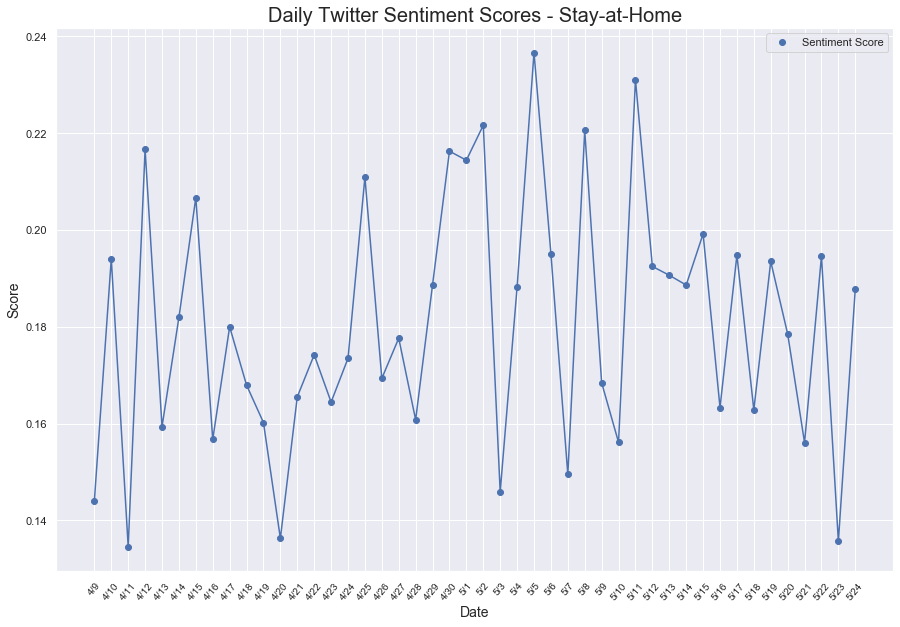

In [239]:
import matplotlib.pyplot as plt

Date = daily_sentiment_VA['Date']
Sentiment = daily_sentiment_VA['Sentiment_Score']

# Date_spikes = daily_sentiment_VA_spikes['Date']
# Sentiment_spikes = daily_sentiment_VA_spikes['Sentiment_Score']

# "bo" is for "blue dot"
plt.figure(figsize=(15, 10))
plt.plot(Date, Sentiment, 'bo', label='Sentiment Score')
plt.plot(Date, Sentiment, 'b')
#plt.plot(Date_spikes, Sentiment_spikes, 'o', color="m", markersize=8)
# b is for "solid blue line"
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Daily Twitter Sentiment Scores - Stay-at-Home', size=20)
plt.xlabel('Date', size = 14)
plt.ylabel('Score', size = 14)
plt.xticks(rotation=50, size=10);
plt.legend()
plt.savefig("DSS-Overall-Stay", tight_layout=False)

plt.show()

## April 19
What happened on __Sunday 4/19__ and __Monday 4/20__ ??? Why did sentiment drop?

The percentage of the Tweets that mention Donald Trump in some capacity is negatively correlated with sentiment with a Pearson’s r of -0.654 statistically significant with a p-value of <.001. See figure below.

Twelve percent of the Tweets on 4/19 mention Trump—which is the third highest day—and comes on the heels of Trump’s controversial 4/17 Tweets about “liberating states” on lockdown, including Virginia:

    “LIBERATE VIRGINIA, and save your great 2nd Amendment. It’s under siege!,” 

Anecdotal evidence suggests the response to Donald Trump over a weekend with fewer Tweets overall and general lower sentiment scores caused this dip.


## May 5
What happened on __Tuesday 5/5__??? Why did sentiment spike?
    - See analysis below - Giving Tuesday day of action: https://www.givingtuesday.org/blog/2020/03/givingtuesday-announces-day-global-action-giving-and-unity-response-covid-19
 
What happened on __Wednesday 5/20__??? Why did sentiment drop?

What happened on __Sunday 5/24__??? Why did sentiment drop?


## Trump Effect
In an effort to identify the cause for the sentiment drop on April 19th, I reviewed the most frequent words in the Tweets for that day. I noticed more references to President Trump (Trump, realdonaldtrump, president) than for other days. The percentage of daily Tweets that mention Donald Trump in some capacity is negatively correlated with sentiment. The more Tweets that reference Trump, the lower the DSS with a Pearson’s r of -.654 statistically significant with a p-value of <.001. Figure 4 shows DSS colored by percentage of daily Tweets that mention Trump. It is worth mentioning that the same correlation does not exist between Virginia Governor Ralph Northam and sentiment score.

Twelve percent of the Tweets on April 19th mention Trump—which is the third highest day—and comes on the heels of Trump’s controversial April 17th Tweets about “liberating states” on lockdown, including Virginia:

 'LIBERATE VIRGINIA, and save your great 2nd Amendment. It’s under siege!'

Anecdotal evidence suggests the response to Donald Trump over a weekend with fewer Tweets overall and lower weekend sentiment scores caused this large drop. 

Figure 4 shows that while April 24th had a high proportion of Tweets mentioning Trump, sentiment score was not correspondingly negative. According to NBC News, “at an April 23 press briefing, President Donald Trump mused about the possibility of using “very powerful light” and injecting disinfectant into the body to kill COVID-19 – a suggestion that, in the case of disinfectant, was roundly criticized by experts as dangerous. A day later, he said he was being “sarcastic.”[6] 

Both “bleach” and “disinfectant” were in the top thirty most frequently used words that day, suggesting that perhaps this was more of a viral moment than an everyday normal reaction to Trump.


In [222]:
trump_stats = pd.read_csv("trump_counts_stay.csv")
trump_stats.head()
daily_sentiment_VA = pd.concat([daily_sentiment_VA, trump_stats], axis=1)
daily_sentiment_VA

,Date,Sentiment_Score,date,not trump,trump,total,% Trump
0,4/9,0.144032,4/9/20,1035,12,1047,0.011
1,4/10,0.194061,4/10/20,1021,11,1032,0.011
2,4/11,0.134525,4/11/20,878,14,892,0.016
3,4/12,0.216664,4/12/20,826,4,830,0.005
4,4/13,0.159334,4/13/20,891,13,904,0.014
5,4/14,0.181931,4/14/20,933,16,949,0.017
6,4/15,0.206674,4/15/20,931,14,945,0.015
7,4/16,0.156706,4/16/20,913,10,923,0.011
8,4/17,0.179988,4/17/20,963,26,989,0.026
9,4/18,0.167936,4/18/20,791,11,802,0.014


In [229]:
# Does Northam have the same affect?
northam_stats = pd.read_csv("northam_counts_stay.csv")
northam_stats.head()

,X1,Not Northam,Northam,Total,% Northam
0,4/9/20,1045,2,1047,0.002
1,4/10/20,1031,1,1032,0.001
2,4/11/20,884,8,892,0.009
3,4/12/20,827,3,830,0.004
4,4/13/20,899,5,904,0.006


In [194]:
# Look at mentions of death/die/died
death_stats = pd.read_csv("death_counts.csv")
death_stats.head()

,d,Not,Death,Total,% Death
0,4/7/20,3870,216,4086,0.0529
1,4/8/20,3750,268,4018,0.0667
2,4/9/20,3577,208,3785,0.0550
3,4/10/20,3201,203,3404,0.0596
4,4/11/20,1988,157,2145,0.0732


In [230]:
daily_sentiment_VA = pd.concat([daily_sentiment_VA, trump_stats, northam_stats,], axis=1)
daily_sentiment_VA

,Date,Sentiment_Score,date,not trump,trump,total,% Trump,date,not trump,trump,total,% Trump,X1,Not Northam,Northam,Total,% Northam
0,4/9,0.144032,4/9/20,1035,12,1047,0.011,4/9/20,1035,12,1047,0.011,4/9/20,1045,2,1047,0.002
1,4/10,0.194061,4/10/20,1021,11,1032,0.011,4/10/20,1021,11,1032,0.011,4/10/20,1031,1,1032,0.001
2,4/11,0.134525,4/11/20,878,14,892,0.016,4/11/20,878,14,892,0.016,4/11/20,884,8,892,0.009
3,4/12,0.216664,4/12/20,826,4,830,0.005,4/12/20,826,4,830,0.005,4/12/20,827,3,830,0.004
4,4/13,0.159334,4/13/20,891,13,904,0.014,4/13/20,891,13,904,0.014,4/13/20,899,5,904,0.006
5,4/14,0.181931,4/14/20,933,16,949,0.017,4/14/20,933,16,949,0.017,4/14/20,940,9,949,0.010
6,4/15,0.206674,4/15/20,931,14,945,0.015,4/15/20,931,14,945,0.015,4/15/20,939,6,945,0.006
7,4/16,0.156706,4/16/20,913,10,923,0.011,4/16/20,913,10,923,0.011,4/16/20,916,7,923,0.008
8,4/17,0.179988,4/17/20,963,26,989,0.026,4/17/20,963,26,989,0.026,4/17/20,970,19,989,0.020
9,4/18,0.167936,4/18/20,791,11,802,0.014,4/18/20,791,11,802,0.014,4/18/20,792,10,802,0.013


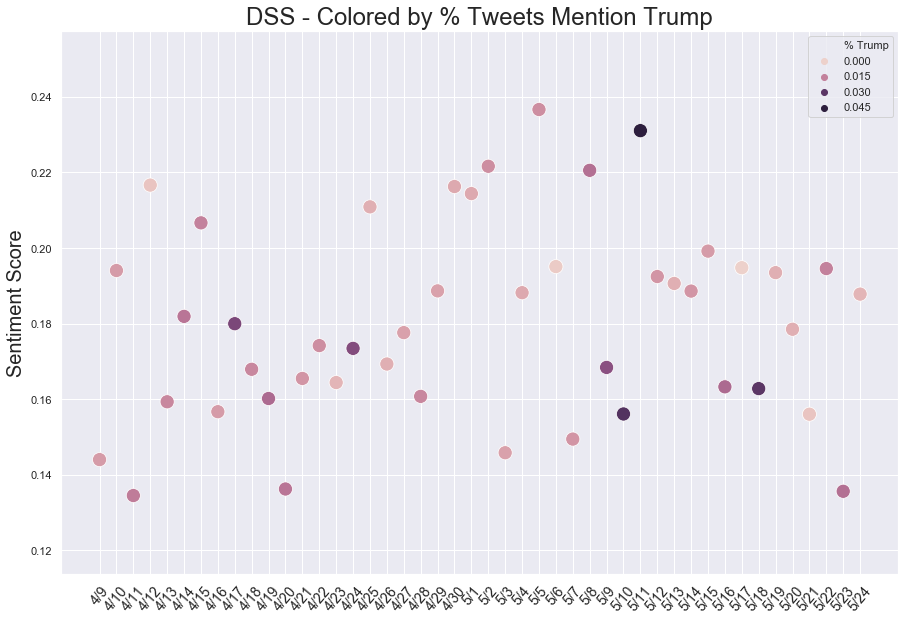

In [225]:
# Daily Sentiment Score by Date - Colored by day type
plt.figure(figsize=(15, 10))
ax = sns.scatterplot(x="Date", y="Sentiment_Score", hue="% Trump",
                     data=daily_sentiment_VA, s=200 ).set_title("DSS - Colored by % Tweets Mention Trump",fontsize=24)
#plt.xlabel("Sentiment Score", fontsize=20)
plt.ylabel("Sentiment Score", fontsize=20)
plt.xlabel("", fontsize=1)
plt.xticks(rotation=50, size=14);
plt.legend()
plt.savefig("DSS-by_Trump", tight_layout=False)
plt.show()

In [226]:
corr, pvalue = pearsonr(daily_sentiment_VA['% Trump'], daily_sentiment_VA['Sentiment_Score'])
print(f'{pvalue:.20f}')
print('Pearsons correlation of reported cases and Sentiment Score: %.3f' % corr)

0.43628384288900240451
Pearsons correlation of reported cases and Sentiment Score: -0.118


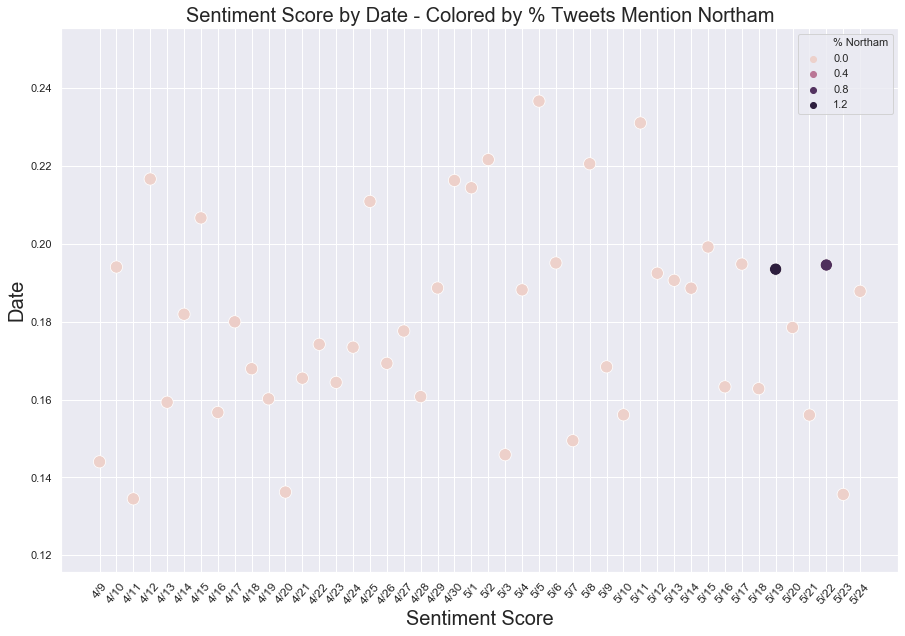

In [231]:
# Daily Sentiment Score by Date - Colored by day type
plt.figure(figsize=(15, 10))
ax = sns.scatterplot(x="Date", y="Sentiment_Score", hue="% Northam",
                     data=daily_sentiment_VA, s=150 ).set_title("Sentiment Score by Date - Colored by % Tweets Mention Northam",fontsize=20)
plt.xlabel("Sentiment Score", fontsize=20)
plt.ylabel("Date", fontsize=20)
plt.xticks(rotation=50, size=12);
plt.legend()
plt.savefig("DSS-by_Northam", tight_layout=False)
plt.show()

In [232]:
corr, pvalue = pearsonr(daily_sentiment_VA['% Northam'], daily_sentiment_VA['Sentiment_Score'])
print(f'{pvalue:.20f}')
print('Pearsons correlation of reported cases and Sentiment Score: %.3f' % corr)

0.46276756665071810959
Pearsons correlation of reported cases and Sentiment Score: 0.111


In [201]:
corr, pvalue = pearsonr(daily_sentiment_VA['% Death'], daily_sentiment_VA['Sentiment_Score'])
print(f'{pvalue:.20f}')
print('Pearsons correlation of reported cases and Sentiment Score: %.3f' % corr)

0.00000127623862513402
Pearsons correlation of reported cases and Sentiment Score: -0.635


## Reviewing Tweets from Specific Day

In [8]:
# Read in final cleaned data from Captsone Analysis
#merged_cleaned_data = pd.read_pickle("merged_cleaned_data_final_200527.pkl")

In [ ]:
# Create county level data set
FFX = merged_cleaned_data

In [292]:
# Identify date for review
#data_0419_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-19']
#data_0520_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-20']
# data_0516_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-16']
#data_0516_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-16']
data_0512_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-12']

In [312]:
# Pull individual daily data sets from cleaned merged data
data_0409_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-09']
data_0410_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-10']
data_0411_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-11']
data_0412_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-12']
data_0413_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-13']
data_0414_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-14']
data_0415_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-15']
data_0416_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-16']
data_0417_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-17']
data_0418_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-18']
data_0419_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-19']
data_0420_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-20']
data_0421_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-21']
data_0422_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-22']
data_0423_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-23']
data_0424_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-24']
data_0425_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-25']
data_0426_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-26']
data_0427_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-27']
data_0428_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-28']
data_0429_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-29']
data_0430_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-30']
data_0501_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-01']
data_0502_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-02']
data_0503_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-03']
data_0504_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-04']
data_0505_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-05']
data_0506_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-06']
data_0507_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-07']
data_0508_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-08']
data_0509_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-09']
data_0510_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-10']
data_0511_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-11']
data_0512_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-12']
data_0513_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-13']
data_0514_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-14']
data_0515_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-15']
data_0516_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-16']
data_0517_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-17']
data_0518_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-18']
data_0519_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-19']
data_0520_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-20']
data_0521_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-21']
data_0522_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-22']
data_0523_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-23']
data_0524_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-24']

In [411]:
#data = data_0505_clean
data = data_0511_clean
len(data)

113

In [412]:
data.county_name.value_counts()

virginia beach city    41
norfolk city           28
chesapeake city        18
newport news city      8 
williamsburg city      7 
suffolk city           4 
portsmouth city        4 
poquoson city          1 
gloucester county      1 
york county            1 
Name: county_name, dtype: int64

In [19]:
#create list of all texts for cleaning
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Create function to run sentiment analysis
def sentiment_score(data):
    text_body=[]
    
    for i in range(0,len(data)):
        temp_text=data['text'].iloc[i]
        text_body.append(temp_text)
    
    analyzer = SentimentIntensityAnalyzer()
    sentences = text_body

    sentiment_score = []
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        sentiment_score.append(vs)
    
        a = pd.DataFrame(sentiment_score)
    #df = pd.concat([a, text_body_df], axis=1)
    return a

In [432]:
dates_cleaned = [data_0409_clean, data_0410_clean, data_0411_clean, data_0412_clean,
                data_0413_clean, data_0414_clean, data_0415_clean, data_0416_clean, data_0417_clean, data_0418_clean, 
                 data_0419_clean, data_0420_clean, data_0421_clean, data_0422_clean, data_0423_clean, data_0424_clean, 
                 data_0425_clean, data_0426_clean, data_0427_clean, data_0428_clean, data_0429_clean, data_0430_clean,
                data_0501_clean, data_0502_clean, data_0503_clean, data_0504_clean, data_0505_clean, data_0506_clean, 
                 data_0507_clean, data_0508_clean, data_0509_clean, data_0510_clean, data_0511_clean, data_0512_clean,
                data_0513_clean, data_0514_clean, data_0515_clean, data_0516_clean, data_0517_clean, data_0518_clean,
                 data_0519_clean, data_0520_clean, data_0521_clean, data_0522_clean, data_0523_clean, data_0524_clean]

In [433]:
# Run sentiment scoring function with current data
sent = sentiment_score(data)


In [456]:
# To get the number of neutral tweets per day
per_neutral = []
score = []

def percent_neutral(data):
    a = sentiment_score(data)
    per_neutral_temp = a.compound.isin([0]).sum() / len(a)
    per_neutral.append(per_neutral_temp)
    score_temp = a.compound.mean()
    score.append(score_temp)
    
    return per_neutral, score

In [457]:
for date in dates_cleaned:
    percent_neutral(date)
   

In [458]:
per_neutral

[0.24,
 0.3021276595744681,
 0.26126126126126126,
 0.22685185185185186,
 0.24401913875598086,
 0.21782178217821782,
 0.2602040816326531,
 0.2511415525114155,
 0.2534562211981567,
 0.21965317919075145,
 0.2275132275132275,
 0.2,
 0.24539877300613497,
 0.2647058823529412,
 0.22631578947368422,
 0.2727272727272727,
 0.25925925925925924,
 0.267515923566879,
 0.16326530612244897,
 0.21666666666666667,
 0.2601626016260163,
 0.26153846153846155,
 0.2028985507246377,
 0.17117117117117117,
 0.29365079365079366,
 0.23853211009174313,
 0.211864406779661,
 0.2222222222222222,
 0.3008849557522124,
 0.23076923076923078,
 0.2413793103448276,
 0.3333333333333333,
 0.18584070796460178,
 0.18556701030927836,
 0.25742574257425743,
 0.24468085106382978,
 0.25882352941176473,
 0.18421052631578946,
 0.1794871794871795,
 0.2564102564102564,
 0.21794871794871795,
 0.19047619047619047,
 0.2289156626506024,
 0.3088235294117647,
 0.2054794520547945,
 0.1864406779661017]

In [459]:
score

[0.08744360000000001,
 0.16975617021276593,
 0.09665225225225225,
 0.2044939814814814,
 0.1346435406698565,
 0.1460272277227723,
 0.1650954081632654,
 0.12149863013698638,
 0.1500963133640553,
 0.17734277456647402,
 0.19438306878306877,
 0.10678702702702696,
 0.16936932515337427,
 0.09099294117647053,
 0.1630678947368421,
 0.1499272727272728,
 0.17254740740740748,
 0.17560828025477707,
 0.1543258503401361,
 0.18377500000000002,
 0.15509024390243908,
 0.2372676923076924,
 0.2335934782608695,
 0.16111711711711715,
 0.09541031746031743,
 0.125508256880734,
 0.1952720338983051,
 0.2137592592592593,
 0.0892079646017699,
 0.29178076923076923,
 0.18981494252873568,
 -0.005697530864197521,
 0.18016194690265486,
 0.061118556701030925,
 0.18426039603960392,
 0.1797329787234042,
 0.1637870588235294,
 0.10732763157894737,
 0.17932820512820508,
 0.09733461538461538,
 0.17738461538461542,
 0.2607333333333334,
 0.10366506024096384,
 0.0730029411764706,
 0.14423561643835617,
 0.16145762711864406]

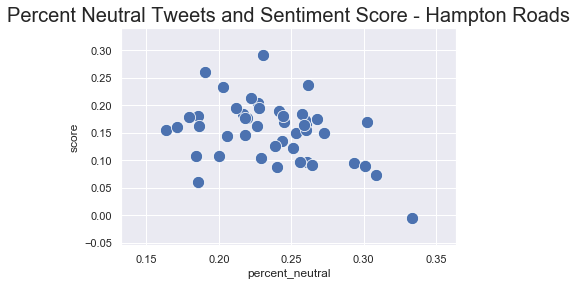

In [467]:
neutral_Hampton = pd.DataFrame(list(zip(per_neutral, score)))
neutral_Hampton.columns=['percent_neutral', 'score']
# Scatter plot of sentiment score by Tweet Frequency
ax = sns.scatterplot(x="percent_neutral", y="score", 
                     data=neutral_Hampton, s=150 ).set_title("Percent Neutral Tweets and Sentiment Score - Hampton Roads",fontsize=20)

#plt.savefig("DSS-Overall by Tweet Frequency - STAY", tight_layout=False)
plt.show()

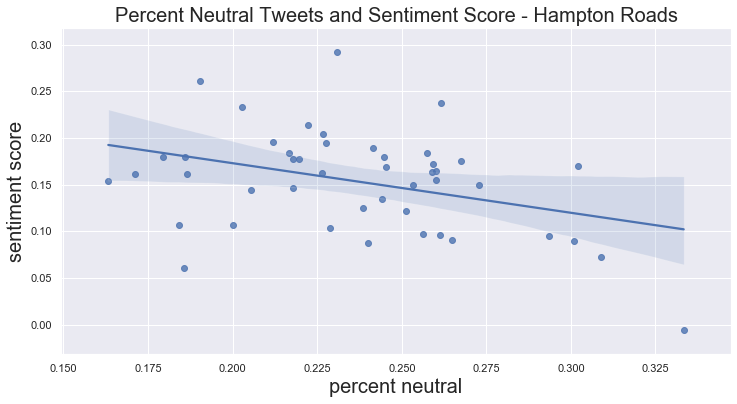

In [469]:
# Avg Weekly Sentiment Score by Percent Change
plt.figure(figsize=(12, 6))
ax = sns.regplot(x="percent_neutral", y="score",
                     data=neutral_Hampton).set_title("Percent Neutral Tweets and Sentiment Score - Hampton Roads",fontsize=20)
plt.savefig("Neutral Tweets", tight_layout=False)
plt.xlabel("percent neutral", fontsize=20)
plt.ylabel("sentiment score", fontsize=20)
plt.show()

In [468]:
corr, pvalue = pearsonr(neutral_Hampton['score'], neutral_Hampton['percent_neutral'])
print(pvalue)
print('Pearsons correlation of sentiment score and neutral tweets: %.3f' % corr)



0.010721110776527924
Pearsons correlation of reported deaths and Sentiment Score: -0.373


In [20]:
#create list of all texts for cleaning
text_body=[]
for i in range(0,len(data)):
    temp_text=data['text'].iloc[i]
    text_body.append(temp_text)
    
text_body_df = pd.DataFrame(text_body)
text_body_df.columns=['text']

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [416]:
data_county = pd.DataFrame(data["county_name"])
data_county.reset_index(inplace=True)

In [417]:
df = pd.concat([sent, text_body_df], axis=1)
len(df)

113

In [431]:
# count neutral counts

df.compound.isin([0]).sum()

21

In [419]:
df = pd.concat([data_county, df], axis=1)
df.sort_values(by="compound")
df.to_csv("HamptonRoads_0508.csv")

In [420]:
#what are hashtags of the data?
data["hashtags"].value_counts()

shopmycloset                                                                                                                                                                                         1
Quarantine                                                                                                                                                                                           1
PSA lockdown Quarantine lifestyle HealthyLiving                                                                                                                                                      1
Repost votd tiktok westindian caribbean guyanese tiktok comedy fun toronto coolie quarantinelife girl dancehall                                                                                      1
aBuse                                                                                                                                                                                                1
quara

In [421]:
df.compound.describe()
# 4/19 had an overall score of .-0.0007853 - very low
# 5//20 had an overall score of  0.066504  - very low for weekday

count    113.000000
mean     0.180162  
std      0.486214  
min     -0.822500  
25%     -0.102700  
50%      0.202300  
75%      0.616400  
max      0.967400  
Name: compound, dtype: float64

In [422]:
df2 = df[['county_name', 'compound']]
df3 = pd.DataFrame(df2.groupby('county_name')['compound'].mean())
df4 = pd.DataFrame(df2.groupby('county_name')['compound'].count())
df3.sort_values('compound')

,compound
county_name,
portsmouth city,-0.012700
virginia beach city,0.088066
norfolk city,0.159914
newport news city,0.199275
chesapeake city,0.233433
suffolk city,0.357625
williamsburg city,0.394029
gloucester county,0.708100
poquoson city,0.710100


In [423]:
df5 = pd.merge(df3, df4, on='county_name')
df5.columns=['sentiment', 'freq']
df5.sort_values(by="sentiment")

,sentiment,freq
county_name,,
portsmouth city,-0.012700,4
virginia beach city,0.088066,41
norfolk city,0.159914,28
newport news city,0.199275,8
chesapeake city,0.233433,18
suffolk city,0.357625,4
williamsburg city,0.394029,7
gloucester county,0.708100,1
poquoson city,0.710100,1


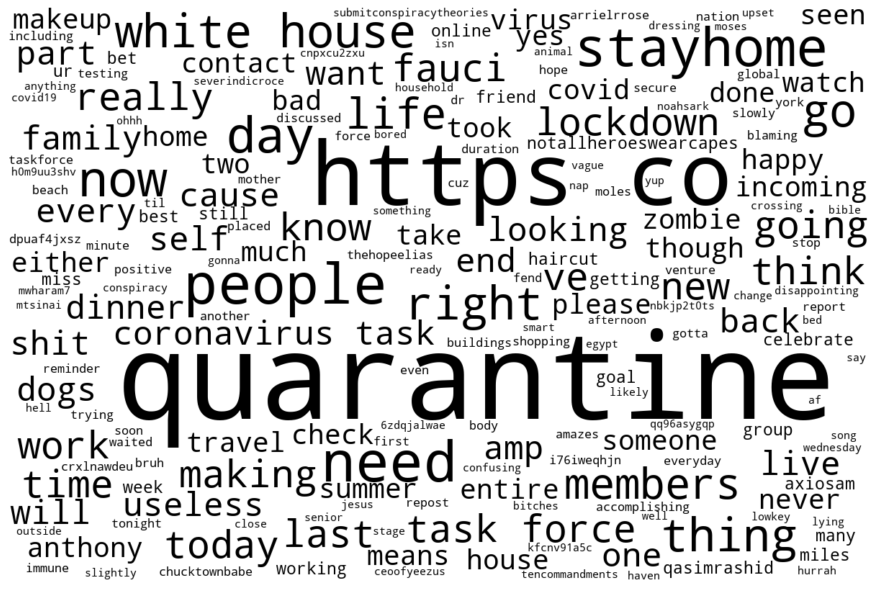

In [280]:
#### Word cloud ####
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
comment_words = ' '
stopwords = set(STOPWORDS) 
 
# iterate through the csv file 
for val in data.text:      
   # typecaste each val to string 
   val = str(val) 
   # split the value 
   tokens = val.split()     
   # Converts each token into lowercase 
   for i in range(len(tokens)): 
       tokens[i] = tokens[i].lower() 
         
   for words in tokens: 
       comment_words = comment_words + words + ' '
# words should all be same color and horizonal 
wordcloud = WordCloud(width = 1200, height = 800, 
               background_color ='white', 
               stopwords = stopwords,prefer_horizontal=1, color_func=lambda *args, **kwargs: "black",
               min_font_size = 10).generate(comment_words) 

# plot the WordCloud image                        
plt.figure(figsize = (12, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig('th.png')
plt.show() 


In [281]:
from nltk.collections import Counter
from nltk.tokenize import TreebankWordTokenizer

tokenizer = TreebankWordTokenizer()
tokenized_sents = [tokenizer.tokenize(i) for i in text_body]
#for i in tokenized_sents:
    #print (i)

In [282]:
# Create a vocabulary document
import functools 
from functools import reduce
tokenized_sents = reduce(lambda x, y: x + y, tokenized_sents, [])

vocab = Counter(tokenized_sents)
print(len(vocab))
#vocab.most_common()

813


# Compare top words in different sets of Tweets

In [289]:
data = data_0510_clean
data.head()

,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,...,profile_banner_url,profile_background_url,profile_image_url,X1,X2,location_cleaned,county_name,X1.1,X2.1,region
2909,x1149317981542989824,x1259328329389412353,2020-05-10 03:44:05,ElueJr,"3 White House coronavirus task force members, including Dr. Anthony Fauci, placed themselves in quarantine after contact with someone testing positive for COVID-19, another reminder that not even the nation's most secure buildings is immune from the virus. https://t.co/DpUAf4jXsz",Twitter for iPhone,280,NaN,NaN,NaN,...,https://pbs.twimg.com/profile_banners/1149317981542989824/1588180211,NaN,http://pbs.twimg.com/profile_images/1255824552187375617/Qbm6mB1T_normal.jpg,2020-05-10,03:44:05,suffolk va,suffolk city,NaN,NaN,3
2972,x503981756,x1259633142987718656,2020-05-10 23:55:18,NateHartman757,@arrielrrose *everyday in quarantine😭,Twitter for iPhone,24,x1259632835209633796,x2857514832,arrielrrose,...,https://pbs.twimg.com/profile_banners/503981756/1460432736,http://abs.twimg.com/images/themes/theme9/bg.gif,http://pbs.twimg.com/profile_images/1259623236632969216/1g4Sf2UE_normal.jpg,2020-05-10,23:55:18,virginia beach,virginia beach city,NaN,NaN,3
3010,x339480434,x1259326221235748867,2020-05-10 03:35:42,MonaSoulMusic,Body goals during this quarantine that I am slowly accomplishing amazes me ☺️,Twitter for iPhone,77,NaN,NaN,NaN,...,https://pbs.twimg.com/profile_banners/339480434/1478793157,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1259339025254662144/0SITi3i1_normal.jpg,2020-05-10,03:35:42,norfolk va,norfolk city,NaN,NaN,3
3011,x339480434,x1259630986456956928,2020-05-10 23:46:44,MonaSoulMusic,New York is the first travel venture I’m going to after quarantine . I need to go shopping bruh,Twitter for iPhone,95,NaN,NaN,NaN,...,https://pbs.twimg.com/profile_banners/339480434/1478793157,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1259339025254662144/0SITi3i1_normal.jpg,2020-05-10,23:46:44,norfolk va,norfolk city,NaN,NaN,3
3020,x115539772,x1259630362852016132,2020-05-10 23:44:15,Mr_SixFt4,@ChucktownBabe Just trying to fend for myself in the quarantine. Happy Mother’s Day too!,Twitter for iPhone,73,x1259630104243814407,x27981666,ChucktownBabe,...,https://pbs.twimg.com/profile_banners/115539772/1584724137,http://abs.twimg.com/images/themes/theme14/bg.gif,http://pbs.twimg.com/profile_images/1257068037230014469/0nNZDD7A_normal.jpg,2020-05-10,23:44:15,newport news va,newport news city,NaN,NaN,3


In [288]:
# ffx = data[data['county_name']=='fairfax county']
# ffx

In [96]:
data = ffx

In [284]:
# Settings for vectorization
STEMMING = False  # judgment call, parsed documents more readable if False
MAX_NGRAM_LENGTH = 2  # Experiment with n-gram length
VECTOR_LENGTH = 250  # set vector length for TF-IDF and Doc2Vec

In [140]:
# Process the data
from nltk.corpus import stopwords

# Function to clean documents
def clean_doc(doc): 
    # split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation)) # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # # filter out short tokens
    #tokens = [word for word in tokens if len(word) > 1]
    # #lowercase all words
    tokens = [word.lower() for word in tokens]
    # Manually clean equivalent classes  
    # # filter out stop words
    stop_words = list(stopwords.words('english'))            
    tokens = [w for w in tokens if not w in stop_words]         
    # # word stemming Commented
    if STEMMING:
        ps=PorterStemmer()
        tokens=[ps.stem(word) for word in tokens]
    return tokens



text_body=[]
for i in range(0,len(data)):
    temp_text=data['text'].iloc[i]
    text_body.append(temp_text)
    
text_body_df = pd.DataFrame(text_body)
text_body_df.columns=['text']

processed_text=[]
# Process documents
for i in text_body:
    text=clean_doc(i)
    processed_text.append(text)
    

final_processed_text=[]
# Combine for final processed text list
for i in processed_text:
    temp_DSI=" ".join(str(item) for item in i )
    final_processed_text.append(temp_DSI)
    

In [286]:
# Check out most frequent words in cleaned data
tokenizer = TreebankWordTokenizer()
tokenized_sents = [tokenizer.tokenize(i) for i in final_processed_text]
tokenized_sents = reduce(lambda x, y: x + y, tokenized_sents, [])

vocab = Counter(tokenized_sents)
print(len(vocab))
vocab.most_common()

541


[('quarantine', 68),
 ('need', 9),
 ('people', 9),
 ('house', 8),
 ('stayhome', 8),
 ('white', 6),
 ('go', 6),
 ('force', 5),
 ('members', 5),
 ('day', 5),
 ('life', 5),
 ('right', 5),
 ('get', 5),
 ('like', 5),
 ('task', 4),
 ('fauci', 4),
 ('new', 4),
 ('going', 4),
 ('last', 4),
 ('really', 4),
 ('think', 4),
 ('lockdown', 4),
 ('work', 4),
 ('making', 4),
 ('today', 4),
 ('know', 4),
 ('coronavirus', 3),
 ('want', 3),
 ('family', 3),
 ('dinner', 3),
 ('cause', 3),
 ('useless', 3),
 ('every', 3),
 ('back', 3),
 ('shit', 3),
 ('time', 3),
 ('things', 3),
 ('thing', 3),
 ('looking', 3),
 ('one', 3),
 ('amp', 3),
 ('dogs', 3),
 ('anthony', 2),
 ('contact', 2),
 ('someone', 2),
 ('virus', 2),
 ('travel', 2),
 ('two', 2),
 ('selfquarantine', 2),
 ('ends', 2),
 ('entire', 2),
 ('got', 2),
 ('days', 2),
 ('done', 2),
 ('much', 2),
 ('either', 2),
 ('summer', 2),
 ('took', 2),
 ('means', 2),
 ('never', 2),
 ('take', 2),
 ('home', 2),
 ('though', 2),
 ('im', 2),
 ('zombie', 2),
 ('incoming',

In [432]:
# # Pull out Tweets with #GivingTuesdayNow to see if that is what is causing sentiment to spike
# data_0419_clean['Trump'] = data_0419_clean['text'].str.contains('trump', case=False).astype(str)
# data_0419_clean.Trump.value_counts()

In [219]:
# Get count/percentage of daily Tweets that mention Trump
searchfor = ['trump', 'president', 'presidenttrump', 'Trump', 'realdonaldtrump', 'donald trump']
merged_cleaned_data['Trump'] = merged_cleaned_data['text'].str.contains('|'.join(searchfor), case=False)
# For times sake, I just copied this into Excel to format and get percentages
trump_counts = merged_cleaned_data[['X1', 'Trump']]
a = pd.DataFrame(trump_counts.groupby('X1').Trump.value_counts())
a.to_csv('trump_counts_stay.csv')

In [220]:
# Get count/percentage of daily Tweets that mention Ralph Northam
searchfor = ['GovernorVA', 'RalphNortham', 'northam', 'Northam', 'governor', 'Governor']
merged_cleaned_data['Northam'] = merged_cleaned_data['text'].str.contains('|'.join(searchfor), case=False)
# For times sake, I just copied this into Excel to format and get percentages
northam_counts = merged_cleaned_data[['X1', 'Northam']]
a = pd.DataFrame(northam_counts.groupby('X1').Northam.value_counts())
a.to_csv('northam_counts_stay.csv')

In [166]:
# Get count/percentage of daily Tweets that mention death

searchfor = ['death', 'deaths', 'died']
merged_cleaned_data['Death'] = merged_cleaned_data['text'].str.contains('|'.join(searchfor), case=False)
# For times sake, I just copied this into Excel to format and get percentages
death_counts = merged_cleaned_data[['X1', 'Death']]
a = pd.DataFrame(death_counts.groupby('X1').Death.value_counts())
a.to_csv('death_counts.csv')

In [424]:
# Get count/percentage of daily Tweets that mention COVID

data = pd.read_pickle('overall_sentiment_STAY.pickle')

searchfor = ['covid', 'COVID', 'coronavirus', 'pandemic']
data['covid'] = data['text'].str.contains('|'.join(searchfor), case=False)
searchfor = ['hair', 'facial hair', 'HAIR', 'haircut']
data['hair'] = data['text'].str.contains('|'.join(searchfor), case=False)
searchfor = ['birthday', 'Birthday', 'bday']
data['birthday'] = data['text'].str.contains('|'.join(searchfor), case=False)
searchfor = ['meantal health', 'depression', 'anxiety', 'crazy']
data['mental'] = data['text'].str.contains('|'.join(searchfor), case=False)
searchfor = ['post quarantine', 'after quarantine', 'after this', 'quarantine ends', 'end of quarantine', 'post covid', 'after covid']
data['post'] = data['text'].str.contains('|'.join(searchfor), case=False)
searchfor = ['trump', 'president', 'presidenttrump', 'Trump', 'realdonaldtrump', 'donald trump']
data['trump'] = data['text'].str.contains('|'.join(searchfor), case=False)
searchfor = ['baking', 'cooking', 'bake', 'cook']
data['baking'] = data['text'].str.contains('|'.join(searchfor), case=False)
searchfor = ['bored', 'boring']
data['bored'] = data['text'].str.contains('|'.join(searchfor), case=False)
# For times sake, I just copied this into Excel to format and get percentages
# death_counts = merged_cleaned_data[['X1', 'Death']]
# a = pd.DataFrame(death_counts.groupby('X1').Death.value_counts())
# a.to_csv('death_counts.csv')

print(data.covid.value_counts(normalize=True))
print(data.hair.value_counts(normalize=True))
print(data.birthday.value_counts(normalize=True))
print(data.mental.value_counts(normalize=True))
print(data.post.value_counts(normalize=True))
print(data.trump.value_counts(normalize=True))
print(data.baking.value_counts(normalize=True))
print(data.bored.value_counts(normalize=True))

False    0.916968
True     0.083032
Name: covid, dtype: float64
False    0.975427
True     0.024573
Name: hair, dtype: float64
False    0.986237
True     0.013763
Name: birthday, dtype: float64
False    0.986132
True     0.013868
Name: mental, dtype: float64
False    0.972126
True     0.027874
Name: post, dtype: float64
False    0.98648
True     0.01352
Name: trump, dtype: float64
False    0.983421
True     0.016579
Name: baking, dtype: float64
False    0.983387
True     0.016613
Name: bored, dtype: float64


In [419]:
trump = data[data['trump']==1]
trump.compound.mean()

-0.08344724637681156

In [420]:
hair = data[data['hair']==1]
hair.compound.mean()

0.13444695898161246

In [421]:
birthday = data[data['birthday']==1]
birthday.compound.mean()

0.4925974747474753

## Cluster Analysis

COVID data set - Using the entire VA data frame, I run VADAR sentiment analysis to get score. 21% of Tweets are neutral (with sentiment=0). The overall sentiment score for the COVID data set is .073. It would make sense to look at the clusters by sentiment grouping. I will start with positive, negative and neutral.

In [5]:
# Select data to use
data = pd.read_pickle('overall_sentiment_STAY.pickle')
data.drop(columns=['index'], inplace=True)
data = data.loc[:,~data.columns.duplicated()]
data

,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,...,X1,X2,location_cleaned,county_name,X1.1,X2.1,neg,neu,pos,compound
0,x174910916,x1248304027772891136,2020-04-09 17:37:27,JonMcLain78,R Americans really stupid enough to think that...,Twitter for Android,252,NaN,NaN,NaN,...,2020-04-09,17:37:27,staunton va,staunton city,NaN,NaN,0.182,0.818,0.000,-0.8648
1,x295761675,x1248290573980708864,2020-04-09 16:43:59,engle_matthew,Social Distancing Day 27: our 14-year old son ...,Twitter for iPhone,225,NaN,NaN,NaN,...,2020-04-09,16:43:59,charlottesville va,albemarle county,NaN,NaN,0.000,1.000,0.000,0.0000
2,x136123969,x1248363319989329921,2020-04-09 21:33:03,daniellelaundon,my number 1 quarantine position is replying to...,Twitter for iPhone,76,NaN,NaN,NaN,...,2020-04-09,21:33:03,richmond va,richmond city,NaN,NaN,0.000,0.885,0.115,0.0772
3,x707817049880465408,x1248387330932523011,2020-04-09 23:08:28,gwu_homo,Has you mental health been negatively impacted...,Twitter for iPhone,61,NaN,NaN,NaN,...,2020-04-09,23:08:28,fairfax va,fairfax city,NaN,NaN,0.000,1.000,0.000,0.0000
4,x2375758213,x1248320847456153600,2020-04-09 18:44:17,ashxeigh,anyone in rva got ac*d i’m trying to transcend...,Twitter for iPhone,60,NaN,NaN,NaN,...,2020-04-09,18:44:17,richmond va,richmond city,NaN,NaN,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28767,x32935580,x1264349625907101697,2020-05-24 00:16:55,ToraCarterMedia,One of the best parts of quarantine has been t...,Instagram,240,NaN,NaN,NaN,...,2020-05-24,00:16:55,virginia beach va,virginia beach city,NaN,NaN,0.000,0.694,0.306,0.9360
28768,x206283535,x1264349052755378177,2020-05-24 00:14:39,waldojaquith,My kids saw both a female summer tanager and a...,Tweetbot for iΟS,199,NaN,NaN,NaN,...,2020-05-24,00:14:39,charlottesville va,albemarle county,NaN,NaN,0.000,0.912,0.088,0.4939
28769,x49790107,x1264347801640722442,2020-05-24 00:09:41,AlexaMQuinn,@AmandaRafkin @evanbirnholz You need to get yo...,Twitter for iPhone,133,x1264344151765561344,x1123320455836852224,AmandaRafkin,...,2020-05-24,00:09:41,charlottesville va,albemarle county,NaN,NaN,0.188,0.812,0.000,-0.7003
28770,x1221505468742410240,x1264347407757819910,2020-05-24 00:08:07,Nasterisk3,Nothin but Ls this quarantine season. https://...,Twitter for Android,37,NaN,NaN,NaN,...,2020-05-24,00:08:07,richmond va,richmond city,NaN,NaN,0.000,1.000,0.000,0.0000


In [6]:
data.compound.value_counts(normalize=True)

 0.0000    0.240651
 0.3612    0.017830
 0.4404    0.017274
 0.4019    0.011504
 0.4215    0.010983
             ...   
-0.8875    0.000035
 0.2744    0.000035
 0.9364    0.000035
 0.8747    0.000035
-0.7841    0.000035
Name: compound, Length: 4390, dtype: float64

In [7]:
# # Group data into positive, negative, and neutral ratings
# positive = data[data['compound']>0]
# negative = data[data['compound']<0]
# neutral = data[data['compound']==0]
# neutral.compound.describe()

In [8]:
# data = positive
# len(data)

In [9]:
# Settings for vectorization
STEMMING = False  # judgment call, parsed documents more readable if False
MAX_NGRAM_LENGTH = 2  # Experiment with n-gram length
VECTOR_LENGTH = 40  # set vector length for TF-IDF and Doc2Vec

In [10]:
import string

In [147]:
from nltk.corpus import stopwords

# Function to clean documents
def clean_doc(doc): 
    # split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation)) # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # Change numbers to words to incorporate years experience
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # # filter out short tokens
    #tokens = [word for word in tokens if len(word) > 1]
    # #lowercase all words
    tokens = [word.lower() for word in tokens]
    # Manually clean equivalent classes
  
    # # filter out stop words
    stop_words = list(stopwords.words('english'))
    stop_words.append('like')
    stop_words.append('amp')
    stop_words.append('quarantine')
    stop_words.append('something')
    stop_words.append('even')
    stop_words.append('really')
    stop_words.append('would')
    stop_words.append('also')
    stop_words.append('though')
    stop_words.append('hey')
    stop_words.append('lol')
    stop_words.append('gotten')
    stop_words.append('got')
    stop_words.append('get')
#     stop_words.append('coronavirus')
#     stop_words.append('covid')
    tokens = [w for w in tokens if not w in stop_words]         
    # # word stemming Commented
    if STEMMING:
        ps=PorterStemmer()
        tokens=[ps.stem(word) for word in tokens]
    return tokens


In [148]:
data['text']

0        R Americans really stupid enough to think that if the curve is flattened, we can just go back to normal? C'mon! Disaster! We would be right back at square one. Let's do this until its GONE! #COVID19 #QuarantineLife #COVIDー19 #ThursdayThoughts #StayHome
1        Social Distancing Day 27: our 14-year old son has taken to riding his little brother’s hoverboard in circles around the house. He calls the threshold to the kitchen “The Boulder Problem.” @AlexHonnold #elcap #SocialDistancing https://t.co/EfE4qUPqSu   
2        my number 1 quarantine position is replying to @mollyguild Instagram stories                                                                                                                                                                                
3        Has you mental health been negatively impacted by quarantine?                                                                                                                                                

In [149]:
#create list of all texts for cleaning
text_body=[]
for i in range(0,len(data)):
    temp_text=data['text'].iloc[i]
    text_body.append(temp_text)
    
# text_body_df = pd.DataFrame(text_body)
# text_body_df.columns=['text']

In [150]:
# Create empty list to store text documents labels (job titles)
processed_text=[]

# Process documents
for i in text_body:
    text=clean_doc(i)
    processed_text.append(text)


In [151]:
len(processed_text)

28772

In [152]:
# Combine for final processed text list
final_processed_text=[]

for i in processed_text:
    temp_DSI=" ".join(str(item) for item in i )
    final_processed_text.append(temp_DSI)
    
type(final_processed_text)
#the following is an example of what the processed text looks like.  
print('\nExample of what one parsed document looks like:\n')
print(final_processed_text[4])


Example of what one parsed document looks like:

anyone rva acd trying transcend


In [153]:
len(data)

28772

In [154]:
RANDOM = 36 # To be reproducible
# Create Job Descriptopn labels to use later
job_labels=[]
sent_label=[]

#Append county_name as label
for i in range(0,len(data)):
    temp_text=data['county_name'].iloc[i]
    job_labels.append(temp_text)
    
for i in range(0,len(data)):
    temp_text=data['compound'].iloc[i]
    sent_label.append(temp_text)

In [155]:
### Sklearn TFIDF 
VECTOR_LENGTH = 300
MAX_NGRAM_LENGTH = 2

# Note the ngram_range will allow you to include multiple-word tokens within the TFIDF matrix
Tfidf=TfidfVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), max_features = VECTOR_LENGTH)
TFIDF_matrix=Tfidf.fit_transform(final_processed_text)     

#creating datafram from TFIDF Matrix
matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns = Tfidf.get_feature_names(), index=sent_label)

In [156]:
Tfidf.get_feature_names()

['able',
 'actually',
 'almost',
 'already',
 'always',
 'amazing',
 'another',
 'anyone',
 'anything',
 'around',
 'ass',
 'away',
 'back',
 'bad',
 'bc',
 'best',
 'better',
 'big',
 'birthday',
 'book',
 'books',
 'bored',
 'break',
 'business',
 'call',
 'cant',
 'care',
 'cause',
 'check',
 'come',
 'coming',
 'community',
 'contact',
 'continue',
 'coronavirus',
 'could',
 'covid',
 'crazy',
 'cut',
 'damn',
 'day',
 'days',
 'definitely',
 'different',
 'distancing',
 'done',
 'dont',
 'due',
 'easter',
 'eat',
 'eating',
 'else',
 'end',
 'enjoy',
 'enough',
 'entire',
 'episode',
 'ever',
 'every',
 'everyone',
 'everything',
 'face',
 'facebook',
 'family',
 'far',
 'favorite',
 'feel',
 'feeling',
 'finally',
 'find',
 'first',
 'food',
 'found',
 'free',
 'friday',
 'friend',
 'friends',
 'fuck',
 'fucking',
 'full',
 'fun',
 'game',
 'getting',
 'give',
 'go',
 'god',
 'going',
 'gonna',
 'good',
 'gotta',
 'great',
 'guys',
 'hair',
 'happy',
 'hard',
 'health',
 'healthy

In [157]:
# ######### MATRIX 1 - Count Vectorization using max vocab words #########
# MAX_NGRAM_LENGTH = 2
# VECTOR_LENGTH=75
# count_vectorizer = CountVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), max_features = VECTOR_LENGTH)
# count_vectors = count_vectorizer.fit_transform(final_processed_text)
# count_vect_df = pd.DataFrame(count_vectors.todense(), columns=count_vectorizer.get_feature_names())
# count_vect_df.head()

In [158]:
#PCA fucntions of word vectors - with and without labels

# PCA Scatterplot
def princomp_scatter_labels(vector):
    pca = PCA(n_components=2, random_state=RANDOM)
    result = pca.fit_transform(vector)
    plt.figure(figsize = (20, 16))
    plt.scatter(result[:, 0], result[:, 1])
    words = list(data['title'])
    for i, word in enumerate(words):
      plt.annotate(word, size = 18, xy=(result[i, 0], result[i, 1]))
    plt.show()
    
def princomp_scatter(vector):
    pca = PCA(n_components=2, random_state=RANDOM)
    result = pca.fit_transform(vector)
    plt.figure(figsize = (10, 7))
    plt.scatter(result[:, 0], result[:, 1])
    plt.show()

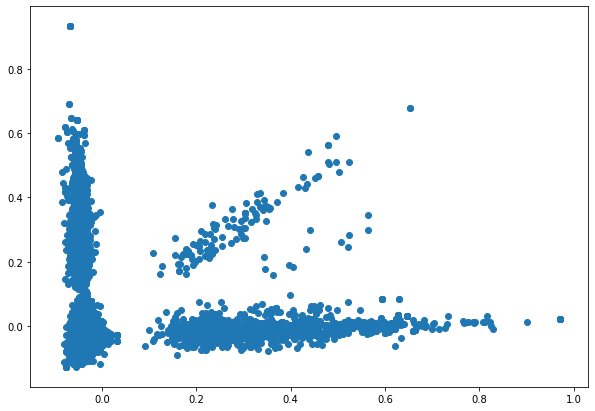

In [159]:
#PCA of count vectorizer
princomp_scatter(matrix) 
#princomp_scatter_labels(count_vect_df)

# Cluster Analysis

I tried clustering the tweets using Kmeans. Results were unsuccesful as tweets seemed to be grouped based on a single word. Tweets are very sparse in terms of meaningful words, and even more so once stop words are removed. I was more successful using LDA topic modeling to group the Tweets as shown below.

In [160]:
# Clustering
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
RANDOM = 36

# Skree plot function
def elbow_plot(df, num_clusters):
    wcss = []
    for i in range(1, num_clusters):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=RANDOM)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
    features = range(1,20)

    plt.plot(features, wcss, '-o', color='black')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

# Silhouette analysis can be used to determine the degree of separation between clusters.
from sklearn.metrics import silhouette_samples, silhouette_score

def silhouette_samples_viz(df, clust_range):
    for i, k in enumerate(clust_range):
        fig, (ax1) = plt.subplots(1, 1)
        fig.set_size_inches(18, 7)
    
        # Run the Kmeans algorithm
        km = KMeans(n_clusters=k)
        labels = km.fit_predict(df)
        centroids = km.cluster_centers_

        # Get silhouette samples
        silhouette_vals = silhouette_samples(df, labels)

        # Silhouette plot
        y_ticks = []
        y_lower, y_upper = 0, 0
        for i, cluster in enumerate(np.unique(labels)):
            cluster_silhouette_vals = silhouette_vals[labels == cluster]
            cluster_silhouette_vals.sort()
            y_upper += len(cluster_silhouette_vals)
            ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
            ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
            y_lower += len(cluster_silhouette_vals)

        # Get the average silhouette score and plot it
        avg_score = np.mean(silhouette_vals)
        ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
        ax1.set_yticks([])
        ax1.set_xlim([-0.1, 1])
        ax1.set_xlabel('Silhouette coefficient values')
        ax1.set_ylabel('Cluster labels')
        ax1.set_title('Silhouette plot for the various clusters', y=1.02);
        
# Function to plot cluster results on PCA map by color
def princomp_scatter_color(vector):
    pca = PCA(n_components=2, random_state=RANDOM)
    result = pca.fit_transform(vector)
    plt.figure(figsize = (10, 7))
    plt.scatter(result[:, 0], result[:, 1], c=kmeans.labels_.astype(float))
    plt.show()
    
# Function to get top 15 words in each cluster - counts
def word_freq_df(dataframe):
    freq = dataframe.sum(axis=0)
    freq = freq.to_frame()
    freq = freq[1:]
    freq = freq.rename(columns={0: "frequency"})
    print(freq.sort_values('frequency', ascending=False).head(20))
    
# Function to get top 15 words in each cluster - mean
def word_mean_df(dataframe):
    freq = dataframe.mean(axis=0)
    freq = freq.to_frame()
    freq = freq[1:]
    freq = freq.rename(columns={0: "mean"})
    print(freq.sort_values('mean', ascending=False).head(15))

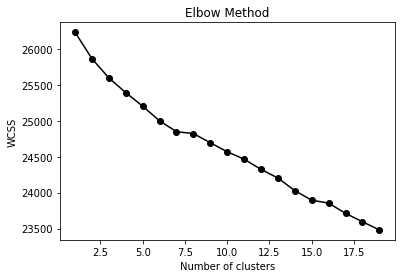

In [25]:
##### Count Vectorizer Elbow Plot #####
elbow_plot(matrix, 20)

In [161]:
# Silhoutte plot
# df = count_vect_df
# clust_range = [2,4,8,11]
# silhouette_samples_viz(df, clust_range)

In [162]:
matrix

,able,actually,almost,already,always,amazing,another,anyone,anything,around,...,working,world,yall,year,years,yes,yet,youre,youtube,zoom
-0.8648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.365436,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
0.0772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.550189,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.9360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
0.4939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
-0.7003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


WCSS: 24478.10175691625


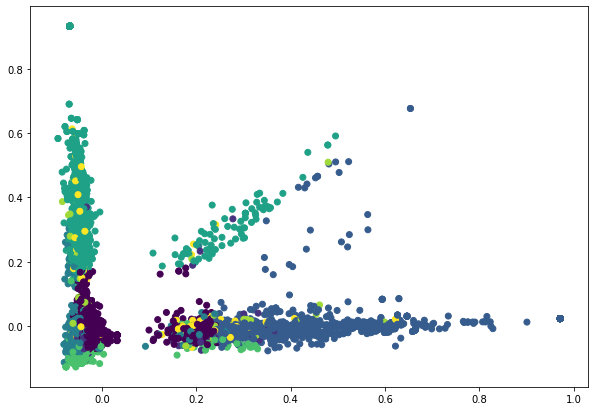

In [163]:
# Cluster Matrix 1 - Count Vectorizer
n_clusters=8
kmeans = KMeans(n_clusters, random_state=RANDOM).fit(matrix)
print('WCSS:', kmeans.inertia_)
labels = kmeans.labels_

princomp_scatter_color(matrix)

In [164]:
# Create dataframe for exploration of clusters
clusters1 = matrix.copy()
clusters1['clusters']= labels #Glue back to original data
clusters1.reset_index(inplace=True)
clusters1 = clusters1.rename(columns={"index": "sentiment"}) # need to get job titles off of index
#clusters1["county_name"] = df["county_name"]
clusters1.clusters.value_counts() # Freqency of clusters

0    18825
3    2441 
4    1669 
5    1559 
2    1316 
1    1204 
7    1009 
6    749  
Name: clusters, dtype: int64

In [31]:
cluster_w_data = pd.concat([data, clusters1], axis=1)

In [38]:
pd.set_option('display.max_colwidth', -1)

/Users/rachelmartonik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [32]:
clusters1.groupby('clusters')['sentiment'].mean()

clusters
0    0.207965
1   -0.211340
2    0.152920
3    0.311941
4    0.173947
5    0.519114
6    0.168164
7    0.063528
Name: sentiment, dtype: float64

In [35]:
pd.options.display.max_rows = 999

In [33]:
# # T-SNE vizualization with clusterung
# sns.set(rc={'figure.figsize':(11.7,8.27)})
# tsne = TSNE(random_state=RANDOM, learning_rate=150, perplexity=50)
# X_embedded = tsne.fit_transform(matrix)
# palette = sns.color_palette("bright", 4)
# y = clusters1['clusters']
# sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette).set_title('t-SNE of Clusters')
# plt.savefig('tSNE_matrix1.png')

In [53]:

CLUST = 1
CLUST_2 = CLUST-1
c = clusters1[clusters1['clusters']==CLUST_2]
c_copy = c.copy()
c_copy.drop(['sentiment', 'clusters'], axis = 1, inplace=True) 
print(word_freq_df(c_copy))
print(len(c))

print(cluster_w_data[cluster_w_data['clusters']==CLUST_2].county_name.value_counts(normalize=True))
cluster_w_data[cluster_w_data['clusters']==CLUST_2].text[100:125]

                   frequency
post              138.872636
new               10.780421 
first             7.934540  
get               5.565414  
day               4.883453  
time              4.850879  
week              4.423059  
check             4.336121  
see               4.313403  
im                4.273319  
one               4.203849  
stayhome          4.174946  
love              4.116515  
gonna             4.058897  
take              3.989005  
going             3.899473  
make              3.851060  
go                3.836072  
know              3.610881  
socialdistancing  3.517352  
None
246
richmond city            0.211382
fairfax county           0.097561
norfolk city             0.077236
loudoun county           0.060976
alexandria city          0.056911
virginia beach city      0.056911
albemarle county         0.052846
arlington county         0.048780
roanoke city             0.028455
montgomery county        0.028455
chesapeake city          0.024390
hampton 

13345    I’m beyond the point where I’d normally get a haircut. Pretty sure this’ll be my post quarantine look... https://t.co/gAoHzuPZWj                                                                                                          
13485    My post quarantine karaoke playlist is getting longer by the day. Apologies in advance to anyone who will witness me bawling and belting at bars in the next year.                                                                        
13542    @DustinPoirier liking my post has been the highlight of my quarantine life https://t.co/BNlfeMPteb                                                                                                                                        
14105    @briochemichelle Post quarantine party theatre edition is happening❤️🎉                                                                                                                                                                    
14141    bout to just ma

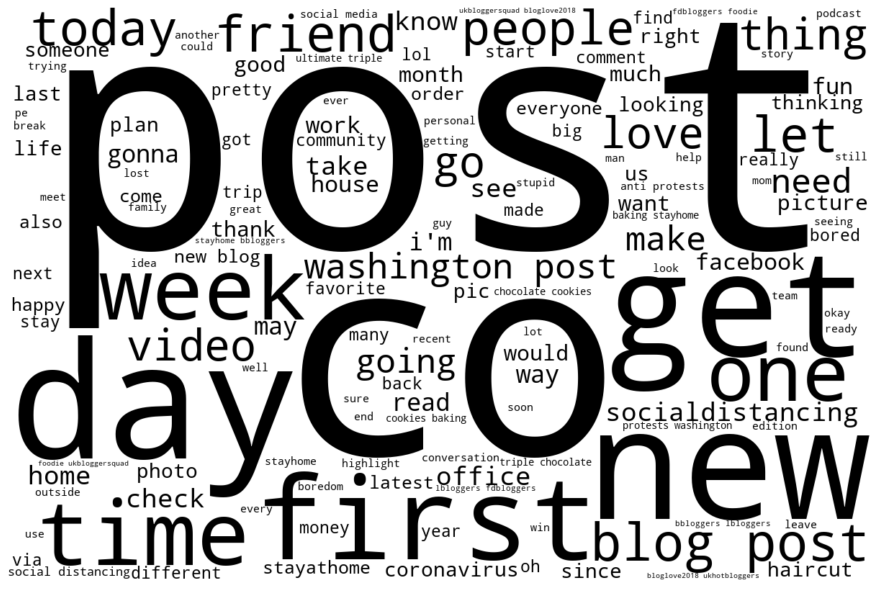

In [144]:
from nltk.corpus import stopwords
#### Word cloud ####
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
comment_words = ' '
stop_words = list(stopwords.words('english'))
stop_words.append('like')
stop_words.append('amp')
stop_words.append('quarantine')
stop_words.append('https')
stopwords=stop_words
 
# iterate through the csv file 
for val in cluster_w_data[cluster_w_data['clusters']==CLUST_2].text:      
   # typecaste each val to string 
   val = str(val) 
   # split the value 
   tokens = val.split()     
   # Converts each token into lowercase 
   for i in range(len(tokens)): 
       tokens[i] = tokens[i].lower() 
         
   for words in tokens: 
       comment_words = comment_words + words + ' '
# words should all be same color and horizonal 
wordcloud = WordCloud(width = 1200, height = 800, 
               background_color ='white', 
               stopwords = stopwords,prefer_horizontal=1, color_func=lambda *args, **kwargs: "black",
               min_font_size = 10).generate(comment_words) 

# plot the WordCloud image                        
plt.figure(figsize = (12, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 


In [40]:
CLUST = 2
CLUST_2 = CLUST-1
c = clusters1[clusters1['clusters']==CLUST_2]
c_copy = c.copy()
c_copy.drop(['sentiment', 'clusters'], axis = 1, inplace=True) 
print(word_freq_df(c_copy))
print(len(c))

print(cluster_w_data[cluster_w_data['clusters']==CLUST_2].county_name.value_counts(normalize=True))
cluster_w_data[cluster_w_data['clusters']==CLUST_2].text[100:150]

          frequency
bad      149.808741
good     7.143458  
really   6.804531  
one      6.659376  
even     6.309974  
people   6.159537  
time     6.077894  
get      6.044605  
im       5.703986  
know     5.439355  
thing    5.422848  
day      5.411897  
think    5.339927  
make     4.890079  
going    4.612728  
maybe    4.442608  
need     4.415398  
feel     4.410252  
making   4.408493  
getting  4.403227  
None
289
richmond city            0.211073
virginia beach city      0.117647
fairfax county           0.055363
loudoun county           0.051903
arlington county         0.044983
norfolk city             0.041522
alexandria city          0.041522
newport news city        0.041522
albemarle county         0.031142
montgomery county        0.031142
roanoke city             0.027682
fairfax city             0.024221
lynchburg city           0.024221
hampton city             0.020761
prince william county    0.017301
manassas city            0.013841
chesterfield county      0.

9885     It’s official, after quarantine is over, national happy hour/drinking times start at 4:00pm and 8:00pm so we can actually go to bed decently early and avoid bad decisions                                                                                                                                                   
9914     @GeorgeMgoblue07 I've thought of shaving my head again - then showers won't seem so urgent... then again, that might be a bad thing? I can't tell in quarantine world                                                                                                                                                        
9955     These two make quarantine not so bad :) https://t.co/jBSKyyDt5m                                                                                                                                                                                                                                                              
10238    Other than

In [41]:
CLUST = 3
CLUST_2 = CLUST-1
c = clusters1[clusters1['clusters']==CLUST_2]
c_copy = c.copy()
c_copy.drop(['sentiment', 'clusters'], axis = 1, inplace=True) 
print(word_freq_df(c_copy))
print(len(c))

print(cluster_w_data[cluster_w_data['clusters']==CLUST_2].county_name.value_counts(normalize=True))
cluster_w_data[cluster_w_data['clusters']==CLUST_2].text[50:80]

                   frequency
day               668.803389
every             42.131295 
one               27.932605 
socialdistancing  22.464654 
today             21.671586 
time              21.252608 
happy             18.772067 
first             17.871225 
another           17.124577 
work              16.747716 
coronavirus       15.683640 
know              15.566270 
think             15.104588 
life              13.378775 
go                13.328096 
im                12.594202 
make              12.578338 
week              12.439756 
still             12.136370 
going             12.065586 
None
1224
richmond city            0.199346
arlington county         0.082516
virginia beach city      0.075163
fairfax county           0.062908
alexandria city          0.061275
albemarle county         0.059641
loudoun county           0.058824
norfolk city             0.057190
fredericksburg city      0.025327
newport news city        0.022876
roanoke city             0.021242
montgom

920     Quarantine Day ???: I’ve decided to will wear a different marathon medal every day that I #stayhome.\n\nBecause while things may be hard right now, medals are not-so-subtle reminders that I’ve done harder things &amp; made it through.\n\nWho’s with me? #medaloftheday       
926     @macguyvermedia Well, quarantine day 4/8...\nI don’t have a clue as to what I’m doing.\nI spend All my days cooking \nI’m forgetting what the day is\nKids want to eat all day\nI want to eat all day (comfort food only)\nZero structure/ Zombie mode                            
930     Day ??? of quarantine: my beard still doesn’t connect...I was under the impression that I was 21                                                                                                                                                                                  
950     Day 26 down of quarantine!! From staff meetings to film breakdowns to recruiting to travel itineraries to professional develop to flipping a ca

In [42]:
CLUST = 4
CLUST_2 = CLUST-1
c = clusters1[clusters1['clusters']==CLUST_2]
c_copy = c.copy()
c_copy.drop(['sentiment', 'clusters'], axis = 1, inplace=True) 
print(word_freq_df(c_copy))
print(len(c))

print(cluster_w_data[cluster_w_data['clusters']==CLUST_2].county_name.value_counts(normalize=True))
cluster_w_data[cluster_w_data['clusters']==CLUST_2].text[50:70]

                   frequency
stayhome          656.799537
staysafe          106.055903
home              72.314551 
coronavirus       64.066942 
stay              44.610523 
today             42.126292 
time              41.491368 
us                38.829850 
safe              38.549248 
virginia          36.466574 
happy             29.359644 
easter            28.084077 
people            27.783719 
thank             27.531910 
one               27.310786 
new               25.963904 
please            25.442208 
socialdistancing  25.049350 
love              24.923220 
day               24.841549 
None
1710
richmond city            0.155556
fairfax county           0.119298
norfolk city             0.081871
alexandria city          0.072515
loudoun county           0.071345
arlington county         0.053801
virginia beach city      0.052047
albemarle county         0.046784
fairfax city             0.034503
prince william county    0.032749
newport news city        0.025731
chesape

549    While most of us are stuck at home these days, we recommend our parents and youth to visit the FREE site https://t.co/Vouy8AePOT for different programs and activities🤩\n\n✨Here are quick and easy instructions to log on and get started‼️ \n\n#stayhome #henricopal #wearepal #staysafe https://t.co/1mXr8mNuNr
575    Thank you, @EITMonline and @DC101 for talking about telemedicine and allowing one of our therapists, @PGP_BlueDevil, to share his experiences with telehealth physical therapy! 🎙️Keeping people safe and healthy at home! 💪 #firsttimelongtime #telemedicine #StayHome https://t.co/W2laQyW37C                   
581    Here’s to dusting off our boomboxes...\nDesign by: Travis Schmidt\n.\n.\n.\n#hueandcry #design #stayhome #quarantunes https://t.co/155RhkSWrU                                                                                                                                                                     
597    Is your team working remotely right now? Are you wo

In [43]:
CLUST = 5
CLUST_2 = CLUST-1
c = clusters1[clusters1['clusters']==CLUST_2]
c_copy = c.copy()
c_copy.drop(['sentiment', 'clusters'], axis = 1, inplace=True) 
print(word_freq_df(c_copy))
print(len(c))


print(cluster_w_data[cluster_w_data['clusters']==CLUST_2].county_name.value_counts(normalize=True))
cluster_w_data[cluster_w_data['clusters']==CLUST_2].text[50:75]

                   frequency
get               578.106852
time              45.824979 
back              42.228368 
need              41.774814 
stayhome          41.689873 
go                40.404803 
people            38.301487 
one               32.490002 
us                31.901741 
day               31.144653 
know              28.698351 
going             28.513832 
want              28.073113 
home              27.883667 
socialdistancing  27.319870 
work              26.503228 
done              26.421764 
help              25.139689 
think             23.120869 
life              23.061535 
None
1540
richmond city            0.197403
virginia beach city      0.096104
fairfax county           0.064935
arlington county         0.063636
norfolk city             0.060390
alexandria city          0.054545
loudoun county           0.050649
albemarle county         0.036364
montgomery county        0.032468
roanoke city             0.025325
prince william county    0.022727
fairfax

1104    being home w ur parents during quarantine is just a lot of them commenting on how many times you go to the kitchen to get more food 😃                                                                                                                                                                          
1128    how my brother get away with doing no chores during quarantine n when i call him out for it my mom wanna come at me 💀 i wonder what it’s like being the favorite                                                                                                                                               
1153    Me trying to get things done during quarantine without moving off the couch...\n\n https://t.co/yn7afCVeP8                                                                                                                                                                                                     
1157    Quarantine no problem. Get in the car son. https://t.co/

In [44]:
CLUST = 6
CLUST_2 = CLUST-1
c = clusters1[clusters1['clusters']==CLUST_2]
c_copy = c.copy()
c_copy.drop(['sentiment', 'clusters'], axis = 1, inplace=True) 
print(word_freq_df(c_copy))
print(len(c))

print(cluster_w_data[cluster_w_data['clusters']==CLUST_2].county_name.value_counts(normalize=True))
cluster_w_data[cluster_w_data['clusters']==CLUST_2].text

                   frequency
good              356.567314
time              25.295971 
thing             23.778132 
one               21.854783 
really            21.418746 
morning           20.816702 
get               17.439430 
day               16.475827 
socialdistancing  15.432414 
look              14.882053 
stayhome          14.395137 
today             13.938704 
know              13.938649 
people            13.764852 
im                13.685175 
think             13.421827 
hair              13.140192 
make              12.959497 
need              12.509971 
since             11.847322 
None
844
richmond city            0.181280
virginia beach city      0.073460
arlington county         0.073460
fairfax county           0.066351
loudoun county           0.056872
albemarle county         0.055687
alexandria city          0.049763
norfolk city             0.047393
roanoke city             0.035545
chesapeake city          0.033175
fairfax city             0.024882
prince w

49       Listening to the Misfits while making dinner. We've been feeling nostalgic today- Fugazi, Lard, Squirrel Nut Zipper, Dead Kennedys, Richard Cheese, Dead Milkmen, Ramones, etc... Quarantine has been good today… https://t.co/jNFwHFcbK5                                                                                                                                                                                                                                                   
175      @Malusxintent @SGhost187 @X_FiLt_TM @Thumperdumper90 @PGA_SNIPES @kearneylad777 All good homie. The servers always get laggy at happy hour. Quarantine problems.                                                                                                                                                                                                                                                                                                                            
249      some v good quarant

In [48]:
CLUST = 7
CLUST_2 = CLUST-1
c = clusters1[clusters1['clusters']==CLUST_2]
c_copy = c.copy()
c_copy.drop(['sentiment', 'clusters'], axis = 1, inplace=True) 
print(word_freq_df(c_copy))
print(len(c))

print(cluster_w_data[cluster_w_data['clusters']==CLUST_2].county_name.value_counts(normalize=True))
cluster_w_data[cluster_w_data['clusters']==CLUST_2].text[100:150]

                   frequency
time              508.633326
socialdistancing  486.139824
people            438.938765
going             407.657266
new               380.640432
one               368.184856
really            350.238102
getting           344.948172
need              333.884546
home              330.907276
go                313.050624
us                309.724778
stayathome        308.048923
know              293.261368
make              278.051544
im                271.439908
still             268.412721
back              267.962306
life              265.954418
would             262.349348
None
21794
richmond city            0.194687
virginia beach city      0.082821
fairfax county           0.062815
arlington county         0.061485
alexandria city          0.059420
norfolk city             0.057631
albemarle county         0.050748
loudoun county           0.049509
fairfax city             0.023355
chesapeake city          0.022850
roanoke city             0.022346
prince

143    I’m RLLY gonna need y’all to stay in your damn houses and stop having ppl over. My loved ones who HAVE to go out in order to work are now starting to be forced into a 2 week quarantine due to other ppl at their job who were irresponsible. This will never end unless you STAY HOME.                                       
145    Quarantine is boring but not dye your hair with box dye boring                                                                                                                                                                                                                                                                 
146    Madi just took one look at me and said “why are you orange” \n\nbecause Madilyn self tanner is a necessary even during quarantine                                                                                                                                                                                              
147    ok. i’m bore

In [50]:
CLUST = 8
CLUST_2 = CLUST-1
c = clusters1[clusters1['clusters']==CLUST_2]
c_copy = c.copy()
c_copy.drop(['sentiment', 'clusters'], axis = 1, inplace=True) 
print(word_freq_df(c_copy))
print(len(c))

print(cluster_w_data[cluster_w_data['clusters']==CLUST_2].county_name.value_counts(normalize=True))
cluster_w_data[cluster_w_data['clusters']==CLUST_2].text[200:300]

           frequency
got       589.217370
really    32.440683 
bored     31.371176 
shit      30.334032 
time      24.640497 
lol       22.904145 
people    21.857061 
looking   20.106909 
us        19.898001 
going     19.041542 
crazy     18.969504 
day       18.789164 
back      17.273650 
new       16.280852 
today     15.320512 
thinking  13.345625 
one       12.904619 
even      12.793984 
know      12.665785 
feeling   12.534438 
None
1125
richmond city            0.244444
virginia beach city      0.099556
norfolk city             0.079111
fairfax county           0.049778
alexandria city          0.043556
loudoun county           0.035556
newport news city        0.034667
albemarle county         0.031111
chesapeake city          0.029333
hampton city             0.027556
arlington county         0.024889
prince william county    0.024889
roanoke city             0.020444
montgomery county        0.017778
fredericksburg city      0.017778
chesterfield county      0.016000
fairf

4597    LOLOLOL I just got my 4th text from now a total of 3 exes during this quarantine and I just....I... https://t.co/pyW3ywSdD7                                                                                                                                                                                      
4601    quarantine got me attached and distant all at once                                                                                                                                                                                                                                                               
4648    Quarantine got me light headed. @ Fredericksburg, Virginia https://t.co/xV3A6DxHVB                                                                                                                                                                                                                               
4672    Got my wife into Justified, so we can quarantine a

In [51]:
CLUST = 9
CLUST_2 = CLUST-1
c = clusters1[clusters1['clusters']==CLUST_2]
c_copy = c.copy()
c_copy.drop(['sentiment', 'clusters'], axis = 1, inplace=True) 
print(word_freq_df(c_copy))
print(len(c))

print(cluster_w_data[cluster_w_data['clusters']==CLUST_2].county_name.value_counts(normalize=True))
cluster_w_data[cluster_w_data['clusters']==CLUST_2].text[50:80]

          frequency
actually  0.0      
seen      0.0      
season    0.0      
school    0.0      
saying    0.0      
say       0.0      
said      0.0      
safe      0.0      
rva       0.0      
run       0.0      
room      0.0      
right     0.0      
remember  0.0      
really    0.0      
real      0.0      
ready     0.0      
reading   0.0      
see       0.0      
self      0.0      
stay      0.0      
None
0
Series([], Name: county_name, dtype: float64)


Series([], Name: text, dtype: object)

In [97]:
CLUST = 10
CLUST_2 = CLUST-1
c = clusters1[clusters1['clusters']==CLUST_2]
c_copy = c.copy()
c_copy.drop(['sentiment', 'clusters'], axis = 1, inplace=True) 
print(word_freq_df(c_copy))
print(len(c))

print(cluster_w_data[cluster_w_data['clusters']==CLUST_2].county_name.value_counts(normalize=True))
cluster_w_data[cluster_w_data['clusters']==CLUST_2].text

                   frequency
stayathome        519.298429
home              47.119500 
coronavirus       33.533577 
stay              25.692301 
us                23.374051 
get               21.506533 
today             20.101906 
time              18.348596 
people            17.582280 
great             15.992638 
one               15.552735 
go                15.193586 
stayhome          14.921223 
socialdistancing  14.814978 
day               12.833763 
None
711
richmond city            0.149086
fairfax county           0.097046
norfolk city             0.088608
loudoun county           0.071730
alexandria city          0.067511
arlington county         0.064698
virginia beach city      0.056259
albemarle county         0.047820
chesapeake city          0.025316
falls church city        0.023910
hampton city             0.022504
fredericksburg city      0.021097
williamsburg city        0.019691
prince william county    0.018284
montgomery county        0.018284
fairfax city     

14       Hardware as a Service is the best way to get the latest @Cisco technology and increase #collaboration adoption with a simple, affordable subscription. Contact us for plan &amp; product details: https://t.co/U0c5ENHavK @CiscoCollab @Webex #remotework #stayathome #telework https://t.co/1q74zPWEDN        
32       Who holds the ALL-TIME SINGLE GAME @NCAA  REBOUNDING RECORD? Wilt Chamberlain? ❌ Bill Russell? ❌  Tim Duncan?  ❌ A William &amp; Mary grad? ✅ \n\nWho was it? Read about it in our new #StayAtHome Series article here! LET'S GO TRIBE 🔰\n\nhttps://t.co/IAzyh4eY04                                            
68       Have to stay active during this #QuarantineLife. Got after a few short runs with the pup today. He’s loving the #StayAtHome lifestyle. #teachertwitter #LMBMSmoves #nikerunning #husky https://t.co/Nf4QBiNUzi                                                                                                 
160      Learn these trigger point techniques in the comfort 

In [98]:
CLUST = 11
CLUST_2 = CLUST-1
c = clusters1[clusters1['clusters']==CLUST_2]
c_copy = c.copy()
c_copy.drop(['sentiment', 'clusters'], axis = 1, inplace=True) 
print(word_freq_df(c_copy))
print(len(c))

print(cluster_w_data[cluster_w_data['clusters']==CLUST_2].county_name.value_counts(normalize=True))
cluster_w_data[cluster_w_data['clusters']==CLUST_2].text

                   frequency
see               443.309544
quarantine        95.356731 
people            28.976075 
socialdistancing  28.432694 
time              25.464634 
get               22.240226 
go                21.903254 
going             21.670519 
today             19.409740 
stayhome          18.392814 
home              17.975867 
one               17.350911 
day               16.966503 
first             16.323107 
everyone          15.737152 
None
655
richmond city          0.192366
virginia beach city    0.082443
fairfax county         0.067176
arlington county       0.064122
albemarle county       0.059542
                         ...   
clarke county          0.001527
richmond county        0.001527
augusta county         0.001527
staunton city          0.001527
franklin county        0.001527
Name: county_name, Length: 67, dtype: float64


55       @Xlib @EWErickson Actually there is a great deal of evidence from other epidemics and pandemics. I suggest you look up the 1918 influenza pandemic. Also quarantine in general works see Samoan islands.                                                                                           
112      @type1Daddy73 Please tell Molly hello from one #SweetGirl to another. You’ve got a rocking artistic talent 👩‍🎨 + I can’t wait to see your next designs!!! Quarantine is hard and #T1D blood sugar roller coasters add extra challenges. But you’re going to be fine. Lots of 💖from across the pond.
218      Check out the big news today! 👀⚽️👏🏻 We miss our players and hope to see you all soon again! #stayhome #stayhealthy #staysafe https://t.co/V48W69kmMc                                                                                                                                               
282      Social distancing with pets makes being home more fun, but an afternoon BBQ is fun too! 

In [99]:
CLUST = 12
CLUST_2 = CLUST-1
c = clusters1[clusters1['clusters']==CLUST_2]
c_copy = c.copy()
c_copy.drop(['sentiment', 'clusters'], axis = 1, inplace=True) 
print(word_freq_df(c_copy))
print(len(c))

print(cluster_w_data[cluster_w_data['clusters']==CLUST_2].county_name.value_counts(normalize=True))
cluster_w_data[cluster_w_data['clusters']==CLUST_2].text

             frequency
day         844.518959
quarantine  248.520471
today       27.245863 
im          20.944452 
know        20.844501 
go          19.466632 
work        19.455659 
think       19.378192 
first       19.204965 
make        18.111932 
good        18.061329 
even        17.129141 
still       16.575923 
home        14.658463 
got         14.325898 
None
1065
richmond city          0.199061
arlington county       0.086385
virginia beach city    0.076056
fairfax county         0.060094
alexandria city        0.059155
                         ...   
salem city             0.000939
alleghany county       0.000939
botetourt county       0.000939
lancaster county       0.000939
bedford county         0.000939
Name: county_name, Length: 72, dtype: float64


42       Quarantine: Day 22 https://t.co/JTbRBlIvmY                                                                                                                                                                        
52       Self quarantine day 20: I bought a bike today                                                                                                                                                                     
80       I been drinking every damn day. Keeps me sane during the quarantine                                                                                                                                               
81       Quarantine Day ??? i started a runescape                                                                                                                                                                          
137      Quarantine day 4567894567 no football got me ready risk it all https://t.co/QUBGGkCCMD                         

In [100]:
CLUST = 13
CLUST_2 = CLUST-1
c = clusters1[clusters1['clusters']==CLUST_2]
c_copy = c.copy()
c_copy.drop(['sentiment', 'clusters'], axis = 1, inplace=True) 
print(word_freq_df(c_copy))
print(len(c))

print(cluster_w_data[cluster_w_data['clusters']==CLUST_2].county_name.value_counts(normalize=True))
cluster_w_data[cluster_w_data['clusters']==CLUST_2].text

                   frequency
love              445.185702
quarantine        89.240531 
stayhome          31.030509 
much              28.738736 
would             25.046369 
people            20.028554 
life              19.547909 
one               19.354059 
us                19.257090 
see               18.164951 
get               18.129005 
socialdistancing  17.615680 
know              16.413339 
time              15.699572 
new               14.633998 
None
643
richmond city          0.200622
virginia beach city    0.105754
fairfax county         0.069984
alexandria city        0.057543
norfolk city           0.052877
                         ...   
washington county      0.001555
rockbridge county      0.001555
scott county           0.001555
galax city             0.001555
franklin county        0.001555
Name: county_name, Length: 67, dtype: float64


44       No, the Christian church is not being persecuted.\n\nYou &amp; your church are being asked to make sacrifices to keep your neighbors safe, to love thy neighbor. \n\nYou can’t save souls if you are unwilling to save lives.\n\nJesus died. All you have to do is #StayHome. Is that so hard? https://t.co/2dMq3L0eHA
56       @genxrob @naughtywriter2 I love Stephanie Ruhle’s quarantine hair! It’s so flippy and full. This was probably my dumbest tweet.                                                                                                                                                                                       
94       Since I won’t be going anywhere this year for my birthday because of quarantine, I ordered myself a little early birthday present. I’m in love 😍 Thank you @HotTopic \n@RiderStrong @daniellefishel @BenSavage @willfriedle https://t.co/OyiTG0IAsg                                                                   
113      In quarantine, sewing face mask

In [101]:
CLUST = 14
CLUST_2 = CLUST-1
c = clusters1[clusters1['clusters']==CLUST_2]
c_copy = c.copy()
c_copy.drop(['sentiment', 'clusters'], axis = 1, inplace=True) 
print(word_freq_df(c_copy))
print(len(c))

print(cluster_w_data[cluster_w_data['clusters']==CLUST_2].county_name.value_counts(normalize=True))
cluster_w_data[cluster_w_data['clusters']==CLUST_2].text

             frequency
really      540.830277
quarantine  136.720529
got         36.977644 
getting     32.269506 
people      24.819959 
time        23.381327 
good        22.290709 
get         20.824342 
think       16.743382 
much        15.495152 
going       15.063168 
know        14.227448 
go          13.748826 
day         12.676232 
im          12.635876 
None
737
richmond city          0.185889
virginia beach city    0.105834
norfolk city           0.070556
arlington county       0.058345
loudoun county         0.050204
                         ...   
king george county     0.001357
manassas park city     0.001357
waynesboro city        0.001357
tazewell county        0.001357
franklin county        0.001357
Name: county_name, Length: 77, dtype: float64


22       Quarantine has really taught me that you can be sick of watching TV😢                                                                                                                                                                                               
46       I think it’s safe to say, I miss shooting and I’m embracing this quarantine really well. #TigerKing #CarModel #QuarantineLife #CaroleBaskin #professionalmodel https://t.co/Vt6V4AKvol                                                                             
86       This quarantine really got me doing workouts in my room like I’m serving 25 to life                                                                                                                                                                                
103      Cleaning out my house during quarantine and I just found a couple random sheets of sandpaper and now everything I own is about to get really smooth.                                    

# Topic Modeling

Topic modeling is a type of unsupervised learning that uncovers “topics” within a text corpus. The topics are represented as a set of the most important words in that topic. The topics help bring structure to a vast amount of unstructured text. Latent Dirichlet Allocation (LDA) is a commonly used algorithm for topic modeling. LDA assumes that each document (Tweet) is a mixture of an arbitrary number of topics selected when training the LDA model. It also assumes that each topic can be represented by a distribution of words [5]. I used the Gensim topic modeling Python package to run the LDA model on the stay-at-home data set. 

In [165]:
# Packages for getting data ready for and building a LDA model
import gensim
from gensim import corpora, models
from pprint import pprint
from gensim.models.coherencemodel import CoherenceModel

# Change this for whatever starting text you are using
text_to_use = final_processed_text

In [197]:
merged_cleaned_data.reset_index(inplace=True)
print(gensim.__version__)

In [198]:
# tokenize sentences
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(text_to_use))

print(data_words[:1])

[['americans', 'stupid', 'enough', 'think', 'curve', 'flattened', 'go', 'back', 'normal', 'cmon', 'disaster', 'right', 'back', 'square', 'one', 'lets', 'gone', 'quarantinelife', 'stayhome']]


Text(0, 0.5, 'Frequency')

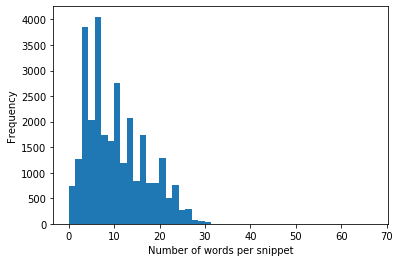

In [199]:
# Remove short reviews
# Create a list for clean snippets.
words_clean = [None] * len(data_words)
# Create a list of word counts for each clean snippet.
word_counts_per_snippet = [None] * len(data_words)

# Process words in all snippets.
for i in range(len(data_words)):
    words_clean[i] = [snippet.lower() for snippet in data_words[i]]
    word_counts_per_snippet[i] = len(words_clean[i])
    
    # Plot a histogram for word counts per snippet, set bins to num of unique values in the list.
plt.hist(word_counts_per_snippet, bins = len(set(word_counts_per_snippet))) 
plt.xlabel('Number of words per snippet')
plt.ylabel('Frequency')

In [200]:
# Convert word counts list and snippets list to numpy arrays.
word_counts_array = np.array(word_counts_per_snippet) 
clean_array = np.array(words_clean) 
print(len(clean_array))

28772


In [170]:
# # Find indices of all snippets where there are greater than or equal to 4 words.
# valid_snippets = np.where(word_counts_array >= 5)[0] 
# print(len(valid_snippets))

22912


In [171]:
# # Subset the clean_array to keep only those where there are at least 4 words.
# clean_array = clean_array[valid_snippets] 
# print(len(clean_array))
# # Convert the array back to a list.
# clean_array = clean_array.tolist() 


22912


In [201]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(clean_array, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[clean_array], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [202]:
# See bigram example
print(bigram_mod[bigram_mod[clean_array[1]]])

['social_distancing', 'day', 'old', 'son', 'taken', 'riding', 'little', 'hoverboard', 'circles', 'around', 'house', 'calls', 'threshold', 'kitchen', 'boulder', 'alexhonnold', 'elcap']


In [203]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# def make_trigrams(texts):
#     return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [204]:
# LEMMNITIZE
# Form Bigrams
data_words_bigrams = make_bigrams(clean_array)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[['stupid', 'enough', 'think', 'curve', 'flatten', 'go', 'back', 'normal', 'cmon', 'disaster', 'right', 'back', 'square', 'let', 'go', 'stayhome']]
[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (6, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (323, 1), (1516, 1)]]


[[('back', 2),
  ('cmon', 1),
  ('curve', 1),
  ('disaster', 1),
  ('enough', 1),
  ('go', 1),
  ('normal', 1),
  ('right', 1),
  ('square', 1),
  ('stayhome', 1),
  ('stupid', 1),
  ('think', 1),
  ('quarantinelife', 1),
  ('one', 1)]]

In [177]:
nlp = spacy.load("en_core_web_sm")

In [205]:
len(corpus) # removed 91 reviews because after cleaning they were 4 words or less

28772

# Building the Topic Model
In addition to the corpus and dictionary, you need to provide the number of topics as well.

__alpha__ and __beta__ are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior. Alpha parameter is Dirichlet prior concentration parameter that represents document-topic density — with a higher alpha, documents are assumed to be made up of more topics and result in more specific topic distribution per document. Beta parameter is the same prior concentration parameter that represents topic-word density — with high beta, topics are assumed to made of up most of the words and result in a more specific word distribution per topic.

__chunksize__ is the number of documents to be used in each training chunk. 

__update_every__ determines how often the model parameters should be updated and passes is the total number of training passes.

The  LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

The relationship between chunksize, passes, and update_every is the following:

__passes:__ Number of passes through the entire corpus

__chunksize:__ Number of documents to load into memory at a time and process E step of EM.

__update_every:__ number of chunks to process prior to moving onto the M step of EM.


--In general a chunksize of 100k and update_every set to 1 is equivalent to a chunksize of 50k and update_every set to 2. The primary difference is that you will save some memory using the smaller chunksize, but you will be doing multiple loading/processing steps prior to moving onto the maximization step. Passes are not related to chunksize or update_every. Passes is the number of times you want to go through the entire corpus. Below are a few examples of different combinations of the 3 parameters and the number of online training updates which will occur while training LDA.

    chunksize = 100k, update_every=1, corpus = 1M docs, passes =1 : 10 updates total
    chunksize = 50k ,  update_every=2, corpus = 1M docs, passes =1 : 10 updates total
    chunksize = 100k, update_every=1, corpus = 1M docs, passes =2 : 20 updates total
    chunksize = 100k, update_every=1, corpus = 1M docs, passes =4 : 40 updates total

In [206]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=25, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=200,
                                           passes=10,
                                           alpha=.6,
                                           per_word_topics=True, 
                                           dtype=np.float64)

In [207]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(22,
  '0.210*"people" + 0.042*"watch" + 0.042*"little" + 0.037*"around" + '
  '0.024*"old" + 0.017*"story" + 0.017*"past" + 0.014*"literally" + '
  '0.014*"taken" + 0.012*"positive"'),
 (4,
  '0.129*"one" + 0.075*"work" + 0.062*"thing" + 0.061*"first" + 0.050*"last" + '
  '0.049*"week" + 0.036*"whole" + 0.027*"able" + 0.025*"weekend" + '
  '0.023*"stop"'),
 (24,
  '0.085*"dont" + 0.056*"coronavirus" + 0.027*"game" + 0.024*"local" + '
  '0.020*"lockdown" + 0.019*"hear" + 0.018*"wine" + 0.018*"art" + '
  '0.017*"honestly" + 0.016*"cool"'),
 (8,
  '0.062*"help" + 0.053*"never" + 0.036*"try" + 0.030*"talk" + 0.026*"play" + '
  '0.023*"nice" + 0.018*"believe" + 0.016*"car" + 0.016*"running" + '
  '0.015*"buy"'),
 (3,
  '0.122*"home" + 0.040*"someone" + 0.039*"bad" + 0.038*"video" + '
  '0.037*"please" + 0.028*"order" + 0.024*"due" + 0.022*"real" + 0.018*"mean" '
  '+ 0.016*"leave"'),
 (15,
  '0.133*"going" + 0.119*"need" + 0.053*"long" + 0.047*"happy" + 0.032*"point" '
  '+ 0.030*"year" +

In [208]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.444220250637917

Coherence Score:  0.3646804619072027


# Number of Topics

Compute the coherance score for a range of topics to see which one performs best

In [120]:
# # Compute the coherance score for a range of topics to see which one performs best
# def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
#     coherence_values = []
#     model_list = []
#     for num_topics in range(start, limit, step):
#         model=gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=num_topics, 
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=200,
#                                            passes=10,
#                                            alpha=.6,
#                                            per_word_topics=True,
#                                            dtype=np.float64)
#         model_list.append(model)
#         coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary,
# coherence='c_v') 
#         coherence_values.append(coherencemodel.get_coherence())
#     return model_list, coherence_values

In [122]:
# start = 2
# limit = 40
# step = 2

# model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, 
#                                                         texts=data_words_bigrams, limit=limit, start=start, step=step)

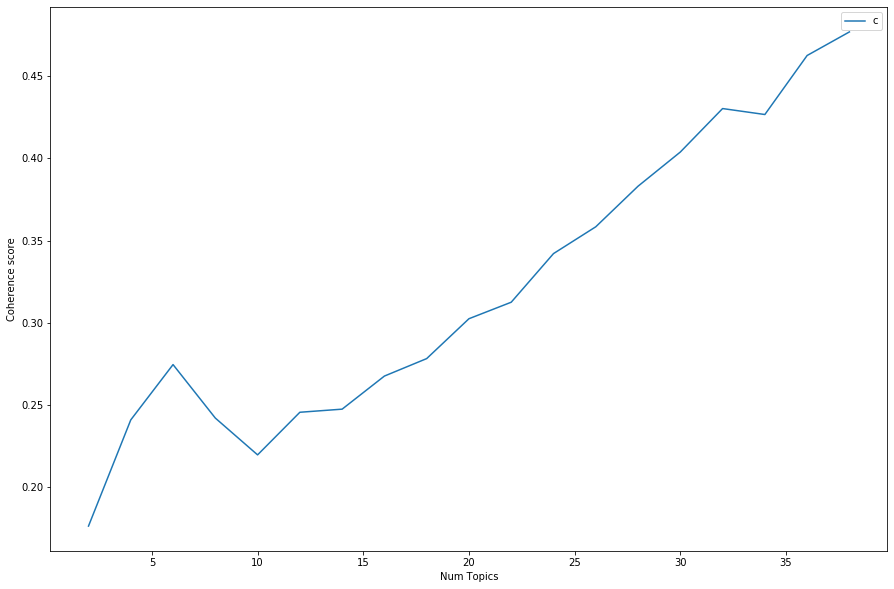

In [123]:
# # Plot graph of topic list
# # Show graph
# import matplotlib.pyplot as plt 
# limit=limit; start=start; step=step;
# plt.figure(figsize=(15, 10))
# x = range(start, limit, step)
# plt.plot(x, coherence_values) 
# plt.xlabel("Num Topics") 
# plt.ylabel("Coherence score") 
# plt.legend(("coherence_values"), loc='best') 
# plt.savefig('pro_coherence_40.png')
# plt.show() 

# #17 best number of negative topics

In [183]:
# # Print the coherence scores
# for m, cv in zip(x, coherence_values):
#     print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:
# # Get the topics with the highest coherence score the coherence for each topic.
# # Shows coherence score for each topic (ranked)
# lda_model.top_topics(corpus=corpus, texts=data_words_bigrams, dictionary=id2word, coherence='c_v', topn=13, processes=-1)

# Topic Visualization

 - Topics in circles closer to each other are closer to each other in meaning
 - Topics farther away are more dissimilar in meaning
 - Circle size is related to the number of documents that contain the topic
      - Topics found in more documents are bigger circles
      - Topics found in fewer documents are smaller circles
      

 - Blue bars represent the overall term frequency in corpus
 - Red bars represent term frequency in selected topic
 - The slider at the top represents the value of lamda, a relevance metric
    - Default is 1 which means that the term's place in the relevance ranking below is solely based on its frequency within a selected topic
     - When 0, the ranking re-arranges itself to be based on the term's frequency within topic with respect to its freuqncy within corpus
     - When set to be between 0 and 1,the ranking will depend on both 

In [209]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
2     -0.328684 -0.278056  1       1        4.435052
4     -0.189782  0.235626  2       1        4.252931
11    -0.162753  0.241754  3       1        4.240297
3      0.016266 -0.022657  4       1        4.173102
16     0.010183 -0.016693  5       1        4.099375
0      0.036614 -0.007501  6       1        4.085997
18     0.011628 -0.000522  7       1        4.076506
19     0.041857 -0.016629  8       1        4.072028
13     0.034083 -0.020554  9       1        4.021774
5     -0.005599  0.012768  10      1        4.014545
21     0.016854 -0.000289  11      1        3.998613
9      0.015301  0.002139  12      1        3.998229
7      0.032064 -0.010360  13      1        3.969558
1      0.034531 -0.013216  14      1        3.946927
23     0.030808  0.003629  15      1        3.943116
17     0.032609 -0.012352  16      1        3.928707
22     0.040982 -0.004693  17      1        3.928031
14     0.034409 -0.014276  18      1        3.907708
8      0.046101 -0.007649  19      1        3.901146
15     0.042117 -0.000921  20      1        3.899681
12     0.030831 -0.013072  21      1        3.870551
24     0.049597 -0.012077  22      1        3.854734
20     0.042496 -0.014490  23      1        3.840934
10     0.041055 -0.017110  24      1        3.830314
6      0.046435 -0.012801  25      1        3.710141, topic_info=                    Term         Freq        Total Category  logprob  loglift
377    people             1749.000000  1749.000000  Default  30.0000  30.0000
152    day                1702.000000  1702.000000  Default  29.0000  29.0000
63     time               1627.000000  1627.000000  Default  28.0000  28.0000
11     stayhome           1316.000000  1316.000000  Default  27.0000  27.0000
1516   one                1164.000000  1164.000000  Default  26.0000  26.0000
157    know               1103.000000  1103.000000  Default  25.0000  25.0000
6364   going              1100.000000  1100.000000  Default  24.0000  24.0000
196    new                1071.000000  1071.000000  Default  23.0000  23.0000
167    home               1081.000000  1081.000000  Default  22.0000  22.0000
380    need               985.000000   985.000000   Default  21.0000  21.0000
0      back               944.000000   944.000000   Default  20.0000  20.0000
6      go                 909.000000   909.000000   Default  19.0000  19.0000
40     today              840.000000   840.000000   Default  18.0000  18.0000
357    still              828.000000   828.000000   Default  17.0000  17.0000
78     good               819.000000   819.000000   Default  16.0000  16.0000
132    make               770.000000   770.000000   Default  15.0000  15.0000
20597  getting            750.000000   750.000000   Default  14.0000  14.0000
61     see                776.000000   776.000000   Default  13.0000  13.0000
375    much               747.000000   747.000000   Default  12.0000  12.0000
13     think              714.000000   714.000000   Default  11.0000  11.0000
8457   dont               693.000000   693.000000   Default  10.0000  10.0000
65     work               681.000000   681.000000   Default  9.0000   9.0000 
71     life               652.000000   652.000000   Default  8.0000   8.0000 
18836  since              628.000000   628.000000   Default  7.0000   7.0000 
243    love               628.000000   628.000000   Default  6.0000   6.0000 
185    many               606.000000   606.000000   Default  5.0000   5.0000 
110    want               615.000000   615.000000   Default  4.0000   4.0000 
9      right              603.000000   603.000000   Default  3.0000   3.0000 
126    best               607.000000   607.000000   Default  2.0000   2.0000 
89     way                570.000000   570.000000   Default  1.0000   1.0000 
63     time               1626.369855  1627.248176  Topic1  -1.7563   3.1151 
61     see                775.

In [ ]:
# Save the plot as a self­contained HTML file.
pyLDAvis.save_html(vis,"POS_LDAvis.html")

In [210]:
# Create dataframe that takes hishest rated topic for each document
doc_num = 25
# Extract the vector of tf_idf weights for the document.
doc_vec = corpus[doc_num] 
print(doc_vec)

doc_topics = lda_model.get_document_topics(doc_vec) 
print(doc_topics)

[(9, 1), (107, 1), (157, 1), (158, 1), (10774, 1), (18836, 1), (20597, 1)]
[(0, 0.027292500577847635), (1, 0.027292578985576407), (2, 0.02728968073183679), (3, 0.027290937470804), (4, 0.027289984382421462), (5, 0.11740199265915637), (6, 0.027294682712148726), (7, 0.027292309182635352), (8, 0.02729220871629123), (9, 0.02729115625365992), (10, 0.027293177331102127), (11, 0.027289946398610217), (12, 0.07281013282428483), (13, 0.07280675123709444), (14, 0.027292068910375448), (15, 0.027292480776368137), (16, 0.027291055557941805), (17, 0.07281054518682539), (18, 0.027290977502725754), (19, 0.027292681907095197), (20, 0.027293393863114013), (21, 0.027291297654472083), (22, 0.027292277868038974), (23, 0.07280724225939819), (24, 0.07281793905017535)]


In [211]:
# Initialize maximum probability score.
max_prob = 0
# Initialize best topic.
best_topic = 0
# Loop over all topics for the document. 
for topic in doc_topics:
    if max_prob <= topic[1]: #if current topic's probability is as high as max 
        max_prob = topic[1] # make current topic's probability the new max 
        best_topic = topic[0] #<­ make current topic best
# Create a tuple with information we just dot.
doc_topic_pair = (doc_num, best_topic, max_prob) 
print(doc_topic_pair)

(25, 5, 0.11740199265915637)


In [212]:
def GetDocTopicPair(doc_num, corpus, lda_model):
    # Extract the vector of tf_idf weights for the document.
    doc_vec = corpus[doc_num]
    # Extract topic probabilities for that document.
    doc_topics = lda_model.get_document_topics(doc_vec) 
    max_prob = 0
    best_topic = 0
    for topic in doc_topics:
        if max_prob <= topic[1]: 
            max_prob = topic[1] 
            best_topic = topic[0]
    doc_topic_pair = (doc_num, best_topic, max_prob) 
    return(doc_topic_pair)

In [213]:
# Create an empty list of the same length as the number of documents.
doc_topic_pairs = [None]*id2word.num_docs 
# Loop through a range of document indices. 
for i in range(id2word.num_docs):
# For each document index, get the document­topic tuple.
    doc_topic_pairs[i] = GetDocTopicPair(i, corpus, lda_model) 
    #print(doc_topic_pairs[100])

In [214]:
# Make a dataframe out of a list of tuples.
doc_topic_pairs_df = pd.DataFrame(doc_topic_pairs)
# Assign column names to the dataframe.
doc_topic_pairs_df.columns = ["doc_id", "best_topic", "best_probability"] 
print(doc_topic_pairs_df.head(25))

    doc_id  best_topic  best_probability
0   0       11          0.186667        
1   1       22          0.244486        
2   2       9           0.088889        
3   3       15          0.094118        
4   4       0           0.091004        
5   5       12          0.100000        
6   6       19          0.118182        
7   7       16          0.142236        
8   8       6           0.076190        
9   9       16          0.094118        
10  10      4           0.165314        
11  11      15          0.136842        
12  12      5           0.200000        
13  13      24          0.040000        
14  14      13          0.368645        
15  15      15          0.084211        
16  16      13          0.255857        
17  17      24          0.130000        
18  18      23          0.209511        
19  19      23          0.080000        
20  20      12          0.136842        
21  21      24          0.086378        
22  22      21          0.094118        
23  23      14  

In [215]:
doc_topic_pairs_df.describe()
# The probability that any one document is assigned to only one topic is relatively low
# Highest single probability is 64% and at 75% percentile highest percentage is 28%

,doc_id,best_topic,best_probability
count,28772.000000,28772.000000,28772.000000
mean,14385.500000,12.414326,0.121427
std,8305.905309,7.323495,0.041178
min,0.000000,0.000000,0.040000
25%,7192.750000,6.000000,0.094118
50%,14385.500000,13.000000,0.113043
75%,21578.250000,19.000000,0.142919
max,28771.000000,24.000000,0.566953


In [253]:
data_raw = pd.read_pickle('overall_sentiment_STAY.pickle')
data_raw.drop(columns=['index'], inplace=True)
data_raw = data.loc[:,~data.columns.duplicated()]
data_raw.head()

,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,...,X1,X2,location_cleaned,county_name,X1.1,X2.1,neg,neu,pos,compound
0,x174910916,x1248304027772891136,2020-04-09 17:37:27,JonMcLain78,"R Americans really stupid enough to think that if the curve is flattened, we can just go back to normal? C'mon! Disaster! We would be right back at square one. Let's do this until its GONE! #COVID19 #QuarantineLife #COVIDー19 #ThursdayThoughts #StayHome",Twitter for Android,252,NaN,NaN,NaN,...,2020-04-09,17:37:27,staunton va,staunton city,NaN,NaN,0.182,0.818,0.000,-0.8648
1,x295761675,x1248290573980708864,2020-04-09 16:43:59,engle_matthew,Social Distancing Day 27: our 14-year old son has taken to riding his little brother’s hoverboard in circles around the house. He calls the threshold to the kitchen “The Boulder Problem.” @AlexHonnold #elcap #SocialDistancing https://t.co/EfE4qUPqSu,Twitter for iPhone,225,NaN,NaN,NaN,...,2020-04-09,16:43:59,charlottesville va,albemarle county,NaN,NaN,0.000,1.000,0.000,0.0000
2,x136123969,x1248363319989329921,2020-04-09 21:33:03,daniellelaundon,my number 1 quarantine position is replying to @mollyguild Instagram stories,Twitter for iPhone,76,NaN,NaN,NaN,...,2020-04-09,21:33:03,richmond va,richmond city,NaN,NaN,0.000,0.885,0.115,0.0772
3,x707817049880465408,x1248387330932523011,2020-04-09 23:08:28,gwu_homo,Has you mental health been negatively impacted by quarantine?,Twitter for iPhone,61,NaN,NaN,NaN,...,2020-04-09,23:08:28,fairfax va,fairfax city,NaN,NaN,0.000,1.000,0.000,0.0000
4,x2375758213,x1248320847456153600,2020-04-09 18:44:17,ashxeigh,anyone in rva got ac*d i’m trying to transcend in quarantine,Twitter for iPhone,60,NaN,NaN,NaN,...,2020-04-09,18:44:17,richmond va,richmond city,NaN,NaN,0.000,1.000,0.000,0.0000


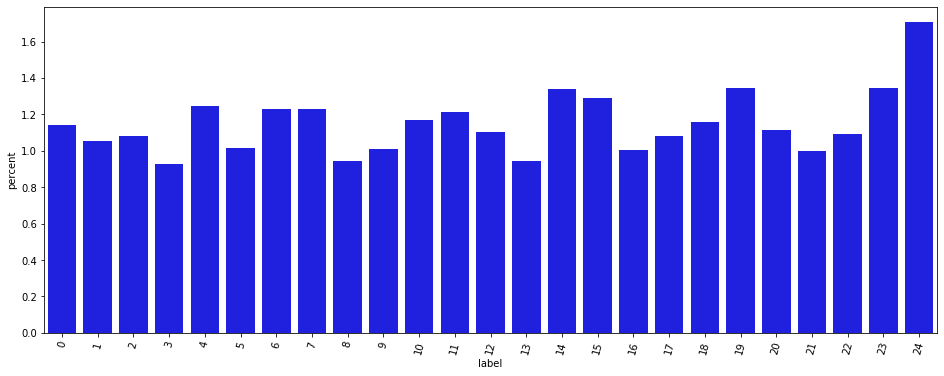

In [254]:


combined = pd.concat([doc_topic_pairs_df, data_raw], axis=1)
combined = combined.sort_values(by="best_probability", ascending = False)
combined.head()

a = pd.DataFrame(combined.best_topic.value_counts(sort=True))
a['percent'] = a['best_topic']/1000
a['label'] = a.index

# Barplot number of topics
plt.figure(figsize=(16, 6))
ax = sns.barplot(x="label", y="percent", data=a, color="b")
plt.setp(ax.get_xticklabels(), rotation=75);

In [267]:
# Sentiment by topic
df3 = pd.DataFrame(combined.groupby('best_topic')['compound'].mean())
df3.sort_values(by="compound")

,compound
best_topic,
10,0.032482
18,0.048410
5,0.059923
11,0.101836
9,0.113600
17,0.131191
14,0.133379
15,0.143149
4,0.143343


In [256]:
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation,strip_numeric

lda_topics = lda_model.show_topics(num_words=25, num_topics=25)

topics = []
filters = [lambda x: x.lower(), strip_punctuation, strip_numeric]

for topic in lda_topics:
    print(topic)
    topics.append(preprocess_string(topic[1], filters))

print(topics)

(0, '0.061*"stay" + 0.059*"everyone" + 0.052*"keep" + 0.037*"hope" + 0.037*"safe" + 0.032*"trying" + 0.031*"definitely" + 0.026*"money" + 0.022*"healthy" + 0.019*"remember" + 0.018*"thinking" + 0.017*"reason" + 0.016*"yet" + 0.015*"follow" + 0.012*"busy" + 0.012*"baking" + 0.010*"hot" + 0.010*"mask" + 0.009*"park" + 0.008*"losing" + 0.008*"somehow" + 0.008*"finding" + 0.007*"figure" + 0.007*"buying" + 0.007*"highlight"')
(1, '0.059*"check" + 0.047*"working" + 0.035*"hard" + 0.035*"different" + 0.034*"social_distancing" + 0.031*"together" + 0.026*"news" + 0.022*"hit" + 0.018*"yall" + 0.017*"bit" + 0.017*"full" + 0.016*"hour" + 0.016*"team" + 0.015*"ask" + 0.014*"spending" + 0.014*"send" + 0.014*"podcast" + 0.012*"training" + 0.010*"essential" + 0.010*"husband" + 0.009*"high_school" + 0.009*"boring" + 0.009*"rather" + 0.008*"clean" + 0.008*"cover"')
(2, '0.173*"time" + 0.082*"see" + 0.033*"pandemic" + 0.031*"put" + 0.024*"via" + 0.022*"learn" + 0.022*"part" + 0.021*"found" + 0.018*"share

In [430]:
topic_num = 0
print(topics[topic_num])
print

['stay', 'everyone', 'keep', 'hope', 'safe', 'trying', 'definitely', 'money', 'healthy', 'remember', 'thinking', 'reason', 'yet', 'follow', 'busy', 'baking', 'hot', 'mask', 'park', 'losing', 'somehow', 'finding', 'figure', 'buying', 'highlight']


<function print>

In [431]:
pd.set_option('display.max_colwidth', -1)
Tweets = pd.DataFrame(combined[combined['best_topic']==topic_num])
print(Tweets.compound.mean())
#pprint(pro_groupings['cons'])
Tweets.text[1:200]

0.31367742782152264


/Users/rachelmartonik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


12976    Are you eating your greens during your quarantine?\n\n•\n•\n•\n•\n•\n#healthy #cleaneating #eatclean #healthyeating #foodie\n#fitspiration #fitnessaddict #instafit #successful #businesstravel #tww #fitnessmotivation #twwt #getfit #business #motivational #businesstravel #roadwarrior https://t.co/sHK2lfOD4X                       
1242     I’ve been trying to keep busy while this quarantine is in effect. I’ve somehow developed a green thumb. Researching and finding out every plants need and figuring out how to duplicate it’s natural environment as… https://t.co/OSHrN7y8wQ                                                                                             
16930    #BestPractice AND #SocialDistancing compliant! First and foremost, we hope you all stay healthy and safe. Second, we hope you continue to #RelyonRynoh during these times. We are here for you! #WFH https://t.co/bFiulHXCvE                                                                                             

In [429]:
len(Tweets)

926

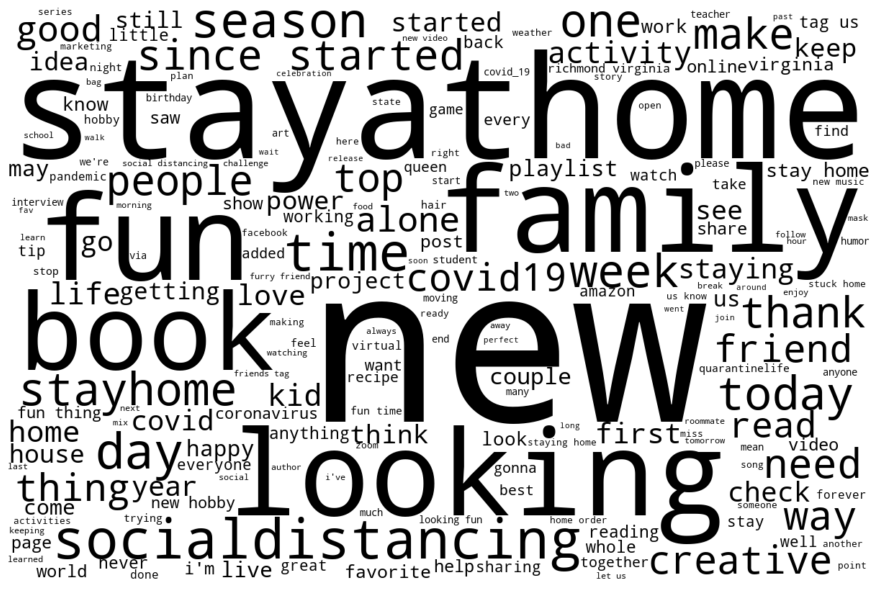

In [412]:
from nltk.corpus import stopwords
#### Word cloud ####
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
comment_words = ' '
stop_words = list(stopwords.words('english'))
stop_words.append('like')
stop_words.append('amp')
stop_words.append('quarantine')
stop_words.append('https')
stop_words.append('co')
stop_words.append('like')
stop_words.append('amp')
stop_words.append('quarantine')
stop_words.append('something')
stop_words.append('even')
stop_words.append('really')
stop_words.append('would')
stop_words.append('also')
stop_words.append('though')
stop_words.append('hey')
stop_words.append('lol')
stop_words.append('gotten')
stop_words.append('got')
stop_words.append('get')
stop_words.append('going')
stop_words.append('made')
# stop_words.append('go')
# stop_words.append('back')

stopwords=stop_words
 
# iterate through the csv file 
for val in Tweets.text:      
   # typecaste each val to string 
   val = str(val) 
   # split the value 
   tokens = val.split()     
   # Converts each token into lowercase 
   for i in range(len(tokens)): 
       tokens[i] = tokens[i].lower() 
         
   for words in tokens: 
       comment_words = comment_words + words + ' '
# words should all be same color and horizonal 
wordcloud = WordCloud(width = 1200, height = 800, 
               background_color ='white', 
               stopwords = stopwords,prefer_horizontal=1, color_func=lambda *args, **kwargs: "black",
               min_font_size = 11).generate(comment_words) 

# plot the WordCloud image                        
plt.figure(figsize = (12, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig("Topic7", tight_layout=False)
plt.show() 

# What People are Tweeting About
To use Twitter as a tracking tool, it is important to understand what people are actually saying in their social media posts. This data set was pulled using “stay-at-home” keywords. As such, we can assume each Tweet had some reference to the coronavirus induced stay-at-home orders given to all Virginians. However, the Tweets can be divided into many subgroups. Using LDA, I was able to pull out 25 “topics” based on the words used in the Tweets. I assigned each Tweet to a topic based on its highest probability of belonging to that group based on the words in the Tweet. I was then able to review the topics with the associated Tweets. While this exercise allowed me to group the topics mathematically, it should be noted that the topics showed extensive overlap and were subjectively named by me. Two basic categories emerged along with many subgroups which are listed below. Color coded word clouds were pulled from Tweets assigned to that topic.

    1 - Coronavirus
         - Illness itself, spread, testing, pandemic
         - Government response, action
         - Quarantine
         - Support
    2 - Life during quarantine
        - Documenting life – “Day X of quarantine…”
        - Working from home, being suck at home
        - Staying safe
        - Keeping busy
            - Baking, cooking, creativity, reading, family fun, tv shows
        - Personal hygiene
        - Facial hair, haircuts, etc.
        - Mental health
            - Depression, anxiety, “going crazy”
        - Birthdays during quarantine
        - Boredom
        - Life after quarantine
        - Relationship - Missing people, things, dating

The stay-at-home data set is far less political than the COVID data set. While the average sentiment score of stay-at-home Tweets that mention Trump is negative (-.083), we simply don’t see the same effect on DSS because the number of Trump tweets is very small. Only 1.35% of the stay-at-home Tweets mention Trump compared to 7.91% in the COVID data set.

The stay-at-home data set is less about COVID-19 specifically than I had anticipated. Only 7.45% of the Tweets mention “COVID”, “COVID-19” or “Coronavirus”, and jumps to 8.30% if you include the word “pandemic.” The data is more focused on life (at home) during quarantine. Almost 2.5% of the Tweets mention “hair”, “facial hair” or “haircut,” and another 1.3% are about birthdays. 1.6% mention being “bored” or “boring,” and another 2.7% talk about “life after quarantine.”

